In [1]:
import numpy as np
import scipy.stats as sp
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
import os 
%matplotlib inline
%precision 4

%config InlineBackend.figure_format = 'retina'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.style.use('ggplot')

%load_ext autoreload
%load_ext watermark
%watermark -d -t -u -v -g -r -b -iv -a "Hongsup Shin" 

numpy      1.17.3
matplotlib 3.1.1
Hongsup Shin 
last updated: 2020-01-14 20:44:57 

CPython 3.7.6
IPython 7.11.1
Git hash: cd1f1a9dc1b7f8ef2cd87ba90a11fe06c5d115e2
Git repo: git@github.com:hongsups/talent-luck-simulator.git
Git branch: master


In [2]:
from talent_v_luck import run_sim_all
from visualize import plot_C_over_t, scatter_talent_capital_P_events, scatter_talent_capital_P_events_comparison

# 1. Introduction
This notebook provides the code and analysis for the simulation data in my blog post [**Talent, luck and success: simulating meritocracy and inequality with stochasticity**](https://medium.com/@hongsupshin/talent-luck-and-success-simulating-meritocracy-and-inequality-with-stochasticity-501e0c1b4969). 

The blog post and the main notebook contains the following:
- Summary and replication of the results from the paper, [Talent vs Luck: the role of randomness in success and failure](https://arxiv.org/abs/1802.07068) (Pluchino et al. 2018)
- Simulating various socioeconomical scenarios including:
	- **Scenario 1. Balanced unlucky events** In the original paper, unlucky events always punished individuals regardless of their talent. Here, individuals with higher talent have higher likelihood of not being affected by bad luck.
	- **Scenario 2. Talent directly affects the return of luck** Talent directly affects how much individuals may profit or lose from the lucky or unlucky events, respectively.
	- **Scenario 3. Paycheck (“Hard work pays off”)** Individuals have fixed income added to their asset (capital) regularly regardless of the luck-related events.
	- **Scenario 4. Interest rate** At every time step (every 6 months), the capital increases based on an interest rate.
	- **Scenario 5. “The rich get luckier, the poor get unluckier”** The rich is more likely to get away with unlucky events but the poor is likely to face unlucky events more often.
	- **Scenario 6. Income tax** Individuals pay income-based tax at every time period.
	- **Scenario 7. Social safety net** One’s capital cannot go lower than the starting amount.

# 2. Analysis on the original paper
## 2.1 The base model: the model from the paper
[The original paper](https://arxiv.org/abs/1802.07068) simulated lucky and unlucky events randomly as if they are [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion) in a two dimensional space. As I mentioned in the blog, mathematically speaking, this is essentially equivalent to simulating a [Bernoulli process](https://en.wikipedia.org/wiki/Bernoulli_process) (i.e., coin-flip with a certain probability). The below describes the model from the original paper with a minor modification, which I generate lucky and unlucky events by doingn a fair coin-flip (50% lucky and 50% unlucky events).

### People / Individuals
There are 1000 individuals. The population size ($N=1000$) does not change during the simulation. This implies that no one dies or reproduces.

### Capital
At the beginning of a simulation, everyone starts with the same amount of capital ($C_{0}=10$). 

### Talent
Everyone has a talent ($T$) parameter, which is drawn from a normal distribution with $\mu_{T}=0.6$ and $\sigma_{T}=0.1$. The talent does not change over time. Since the talent follows a normal distribution, technically it can be negative or larger than 1, but for convenience $0 \leq T \leq 1$. 

### Time
A single run of the simulation is equal to 40 years of working life (from age 20 to 60). Each time step is 6 months, so there are **80 time steps** in total. The original paper used a 2D simulation but let's use Bernoulli process to simplify the simulation. 

### Events and simulation
At every time step $t$, each individual, $i$, there is a probability, $P_{event}$, that an event happens. 

$$E_{i, t} \sim Bernoulli(P_{event})$$

If $E_{i, t}=1$, either a lucky or an unlucky event occurs. There’s a probability of $P_{lucky}$ of the event being lucky (in the origianl paper ($P_{lucky}=0.5$). Otherwise ($E_{i, t}=0$), nothing happens. $P_{event}$ and $P_{lucky}$ do not change over time.

This way, it is easy to quantify and understand the stochastic nature of luck. For instance, if $P_{event} = 0.1$, a lucky or an unlucky event occurs every 5 years on average. Everything else is the same as the original model in the paper (equal start of capital, normally distributed talent, etc.). For every person, $P_{event}$ does not change over time. By defining an event in a probablistic way, it is easy to control and quantify the lucky and unlucky events.

### A lucky event
When a lucky event happens, a person's capital is doubled but **only if they are talented enough** to get profit out of it (i.e., only if a random draw between 0 and 1 is smaller than your talent):
$$x_{i, t} \sim U(0,1)$$
$$C_{i, t+1} = \begin{cases} 2C_{i, t} & x_{i, t} < T \\
                          C_{i, t} & x_{i, t} \geq T
            \end{cases}$$

### An unlucky event
When an unlucky event happens, your capital is **always** halved:
$$C_{i, t+1} = 0.5C_{i, t}$$

### Simulation result from a single run
I defined the $P_{event} = 0.1$. This means on average, there is one lucky or unlucky event every 5 years.

In [3]:
# no. of individuals
N = 1000 

# mean, std talent
mu_T = 0.6 
std_T = 0.1

# 40 years, every 6 months
N_timestamps = 80 

# one lucky or unlucky event for every 10 years
P_event = 0.1

# if an event happens there's prob. of P_lucky that the event is lucky
P_lucky = 0.5
P_unlucky = 1 - P_lucky

# initial capital value
C_0 = 10

In [4]:
def lucky_event(C_prev, T, coeff=2):
    
    # compute the consequence of a lucky event
    # C_prev: previous capital amount
    # T: talent
    # coeff: linear coefficient to C_prev
    
    x = np.random.random()
    if x < T:
        C_next = coeff*C_prev
    else:
        C_next = C_prev    
    return C_next

def unlucky_event(C_prev, T, coeff=1/2, balanced='False'):
    
    # compute the consequence of an unlucky event (based on the original paper)
    # individuals are always affected by the event
    # C_prev: previous capital amount
    # T: talent
    # coeff: linear coefficient to C_prev

    if balanced:
        x = np.random.random()
        if x >= T:
            C_next = coeff*C_prev
        else:
            C_next = C_prev    
    else:
        C_next = coeff*C_prev
    return C_next

In [5]:
def run_sim(P_event=0.1, P_lucky=0.5, coeff_lucky=2, coeff_unlucky=1/2, 
            C_0=10, N_timestamps=80, mu_T=0.6, std_T=0.1, N=1000, T_dist='normal', balanced='False'):

    # simulate the talent-vs-luck model
    # P_event: probability of an event (lucky or unluycky) happening
    # P_lucky: probability of an event being lucky 
    # coeff_lucky: linear coefficient to the capital for a lucky event
    # coeff_unlucky: linear coefficient to the capital for an unlucky event
    # C_0: initial amount of capital
    # N_timestamps: number of simulation runs
    # mu_T: talent mean
    # std_T: talent stdev
    # N: population size
    
    # create individuals w/ different talents and clip the talent between 0 and 1
    if T_dist == 'normal':
        Ts = np.clip(np.random.normal(mu_T, std_T, N), 0, 1)
    elif T_dist == 'uniform':
        Ts = np.random.random(N)
    
    Cs = []
    for T in Ts: # for each individual
        
        # generate the entire history of events
        events = np.random.binomial(1, P_event, N_timestamps)

        C = C_0
        for event in events:
            if event == 0:
                C = C
            else:
                luckiness = np.random.random()<P_lucky
                if luckiness:
                    C = lucky_event(C, T, coeff_lucky)
                else:
                    if balanced:
                        C = unlucky_event(C, T, coeff_unlucky, True)
                    else:
                        C = unlucky_event(C, T, coeff_unlucky, False)
        Cs.append(C)
    return Cs, Ts

In [6]:
Cs, Ts = run_sim(P_event=0.1, P_lucky=0.5, coeff_lucky=2, coeff_unlucky=1/2, 
                 C_0=10, N_timestamps=80, mu_T=0.6, std_T=0.1, N=1000, balanced=False)

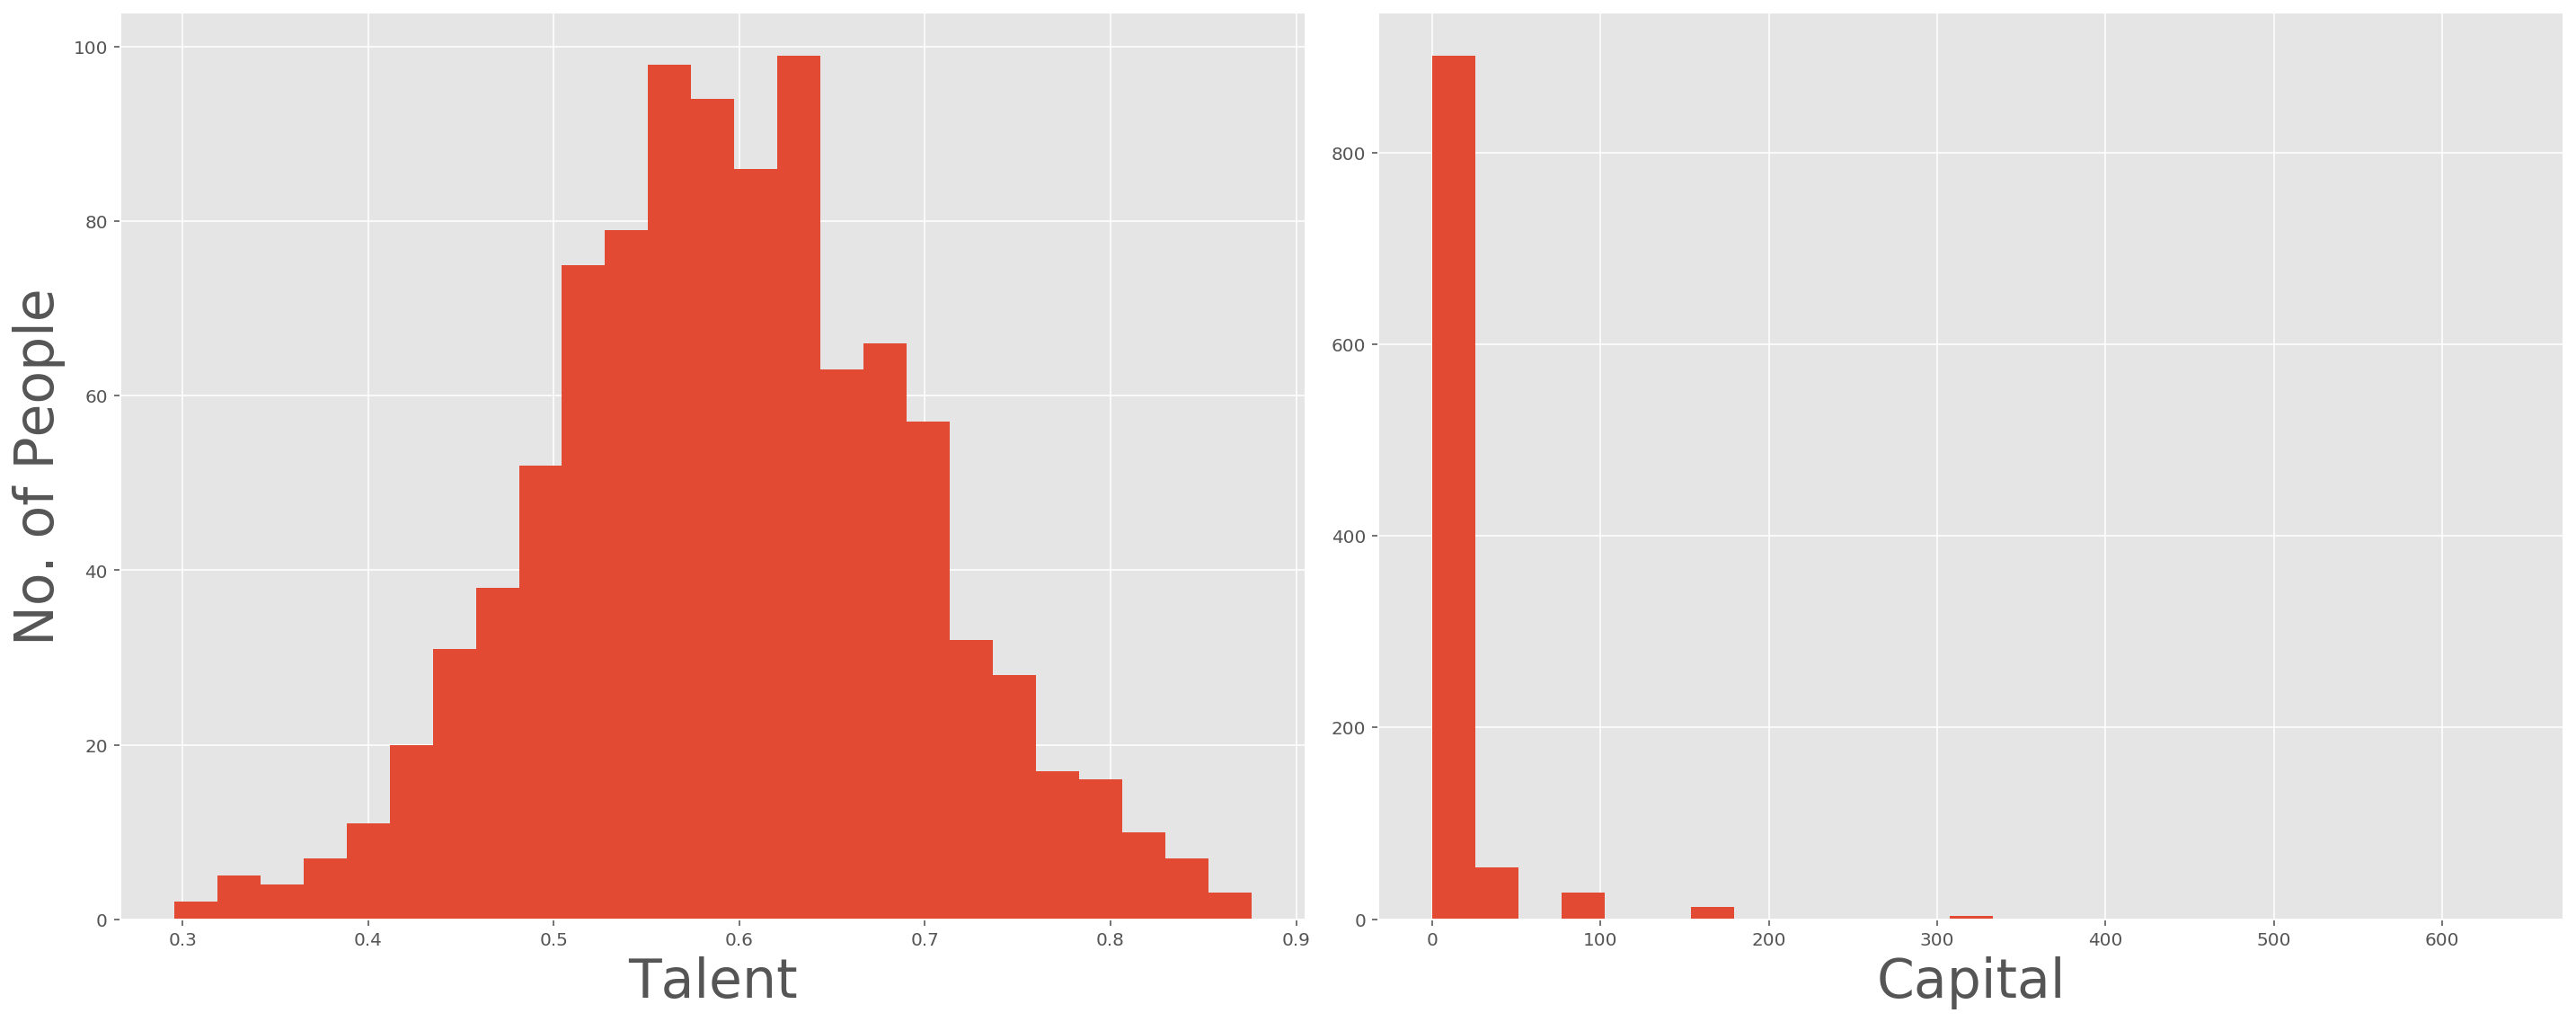

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))

fontsize = 30
axes[0].hist(Ts, bins=25)
axes[0].set_xlabel('Talent', fontsize=fontsize)
axes[0].set_ylabel('No. of People', fontsize=fontsize)

axes[1].hist(Cs, bins=25)
axes[1].set_xlabel('Capital', fontsize=fontsize)

plt.tight_layout()
plt.savefig('Figures/talent_capital_hist_original_model.png')
plt.show()

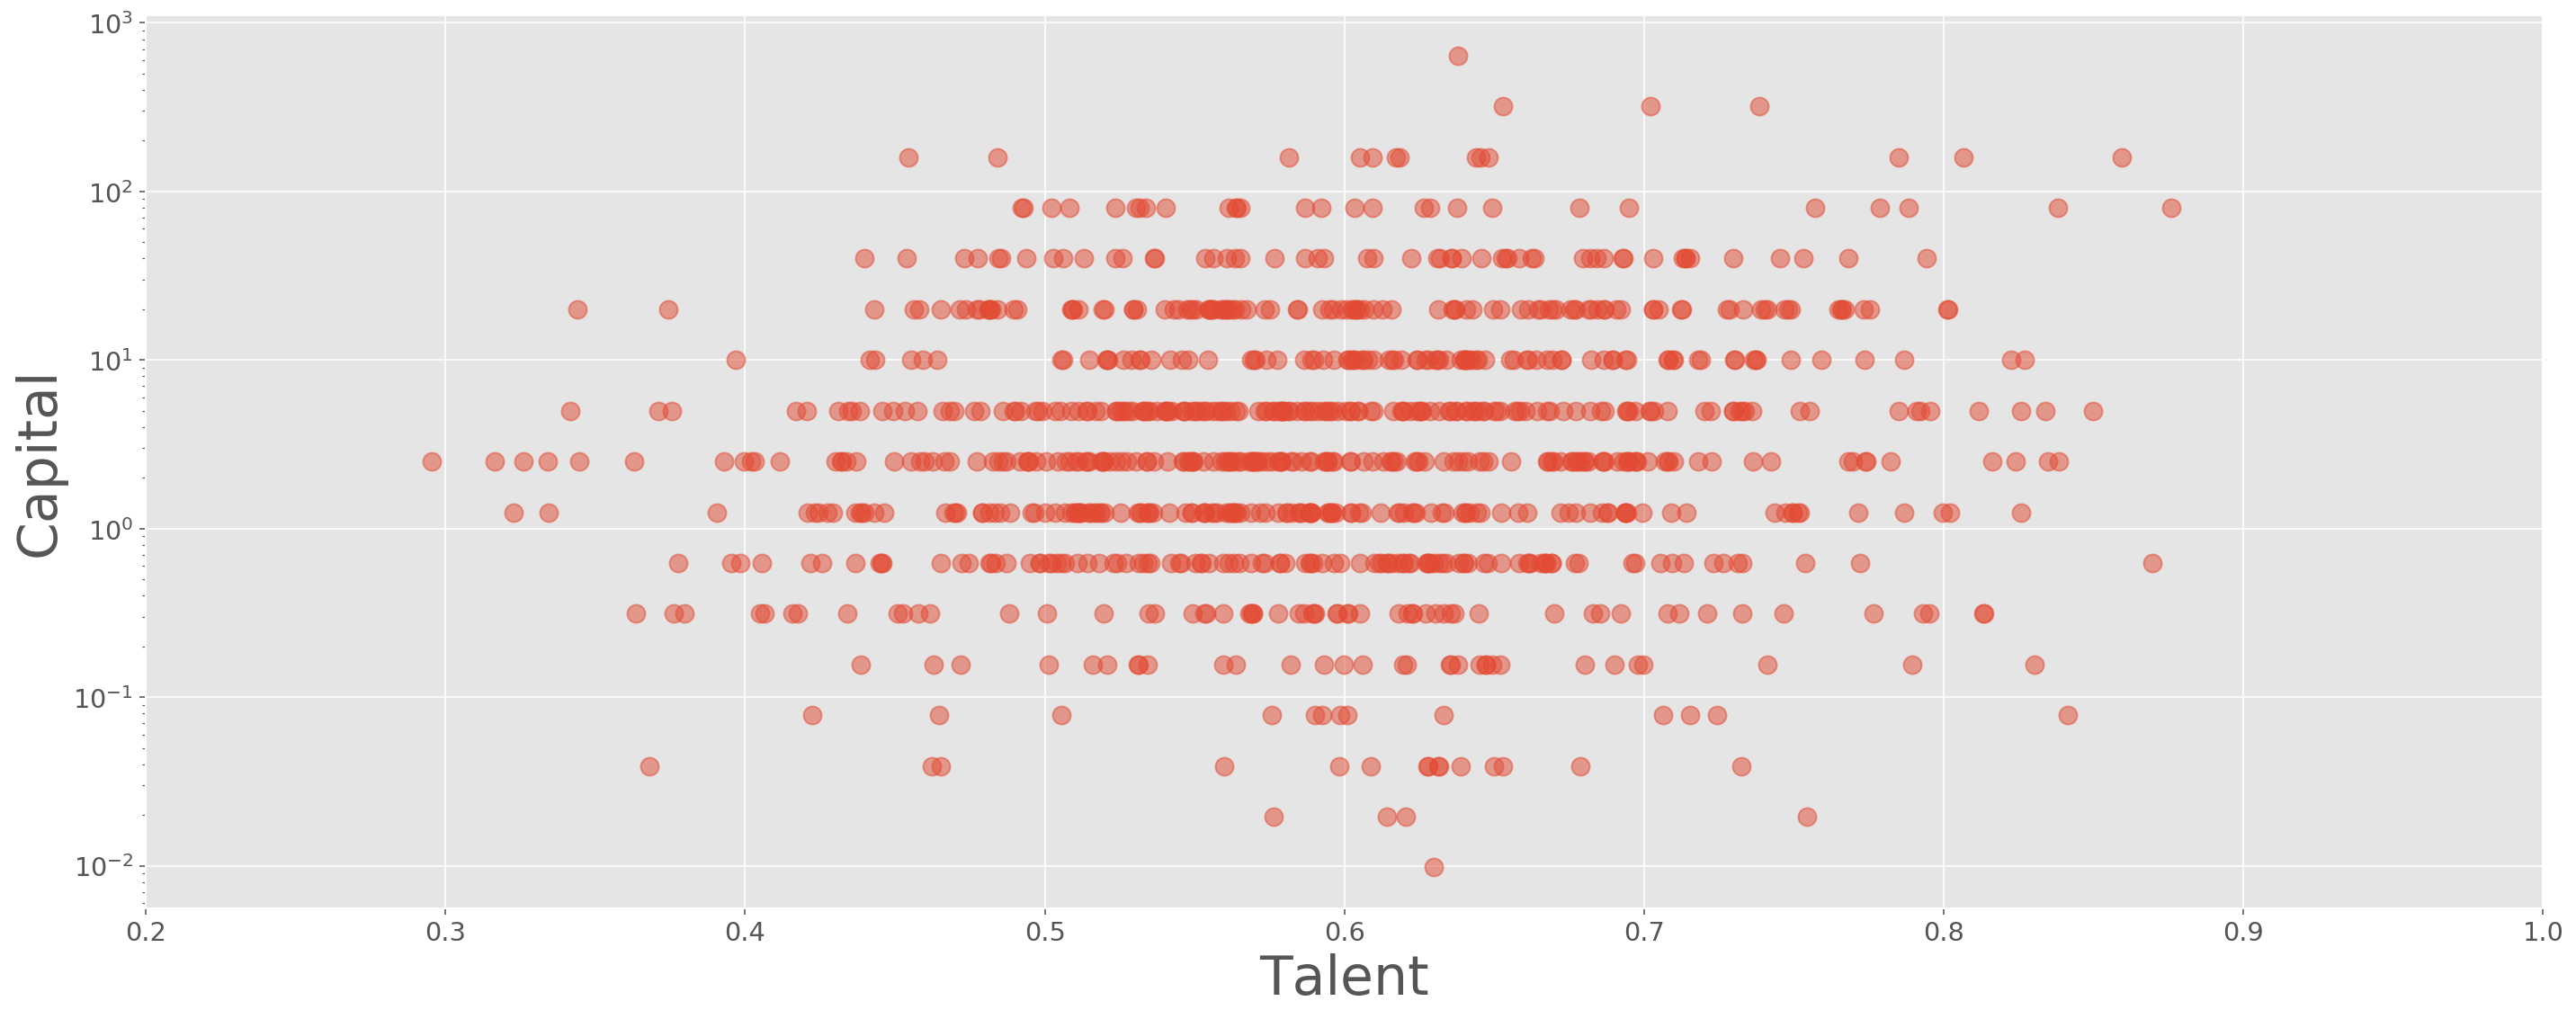

In [8]:
plt.figure(figsize=(20,8))
plt.plot(Ts, Cs, 'o', alpha=0.5, markersize=10)
plt.xlim(0.2,1)
plt.xlabel('Talent', fontsize=30)
plt.ylabel('Capital', fontsize=30)
plt.yscale('log')
plt.tick_params(labelsize='x-large')
plt.tight_layout()
plt.savefig('Figures/capital-talent-scatter-original_model.png');

## 2.2 Comparing normally and uniformly distributed talents

In [9]:
Cs_normal, Ts_normal = run_sim(P_event=0.1, P_lucky=0.5, T_dist='normal')
Cs_uniform, Ts_uniform = run_sim(P_event=0.1, P_lucky=0.5, T_dist='uniform')

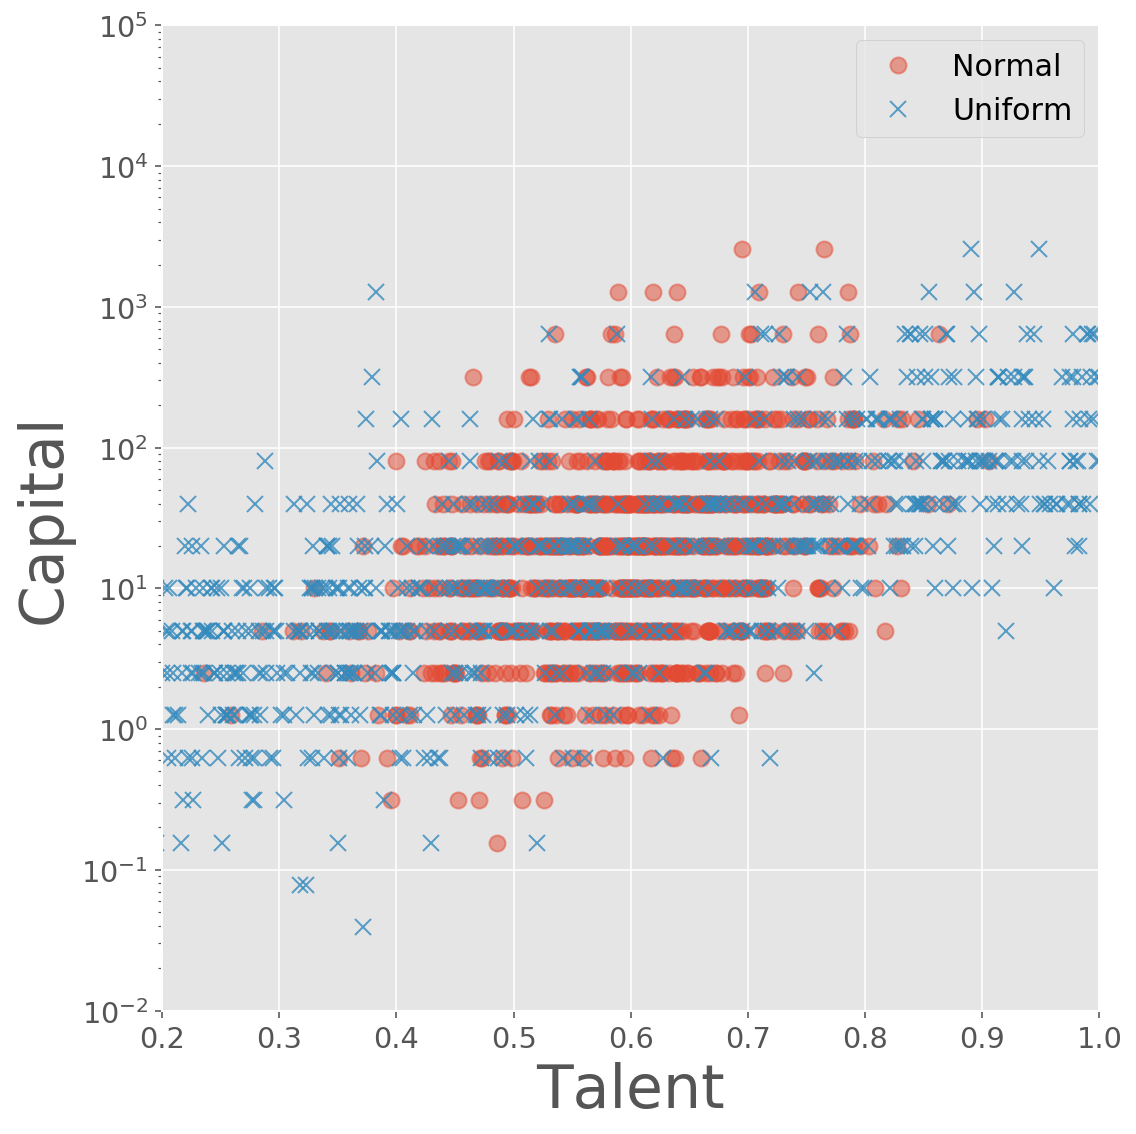

In [10]:
plt.figure(figsize=(8,8))
plt.plot(Ts_normal, Cs_normal, 'o', alpha=0.5, markersize=8)
plt.plot(Ts_uniform, Cs_uniform, 'x', alpha=0.8, markersize=8)
plt.xlim(0.2,1)
plt.ylim(0.01, 100000)
plt.xlabel('Talent', fontsize=30)
plt.ylabel('Capital', fontsize=30)
plt.yscale('log')
plt.tick_params(labelsize='x-large')
plt.legend(['Normal', 'Uniform'], fontsize=15)
plt.tight_layout()
plt.savefig('Figures/capital-talent-scatter-default.png');

The authors of the paper claim that luck plays the key role to select most successful individuals as the authors claimed. It's a bit more nuanced than that. We have too few samples for the highly talented because in the paper, the talent is normally distributed. In this model, capital is only increased by lucky events. Although talent helps get profit out of a lucky event, since the probability of having multiple lucky events is small, the expected number of average-talented people getting lucky multiple times is higher than the high-talented people simply because there are more average-talented people. We can confirm this idea by using uniformly distributed talent (shown in blue crosses above). Now, the average-talented are less likely to outperform the high-talented. In fact, there is a positive trend, showing that highly talented people tend to be wealthier than others. Hence, it is the interplay between stochasticity (luck) and normally distributed talent that makes it look like average people are doing better than the talented, not just the randomness itself.

# 3. Talent, luck and meritocracy

This paper tackles the idea of meritocracy, which affects many aspects of our lives and society. Assuming that talent is an inherent trait, it would be interesting to see how luck affects the relationship between talent and success. The talent-capital scatter plot can visualize meritocracy, economic inequality, and stochasticity (see below). 

<img src="Figures/meritocracy_stochasticity.png" width="640"/>

- If talent and capital show positive correlation, we can say that the world is meritocratic; the more talented you are, the more successful you are likely to be.
- Due to luck, inevitably there is a degree of stochasticity, which creates a cloud of dots, not a straight line. If there is a wide spread of dots at a given talent value, you may say the world is more stochastic (more luck-driven), which in turn, makes it less meritocratic because then the talented are no more successful than the average.
- The width of capital distribution is a measure of economic inequality. The wider it becomes, the more inequality exists.

## 3.1 The effect of stochasticity ($P_{event}$)
In the new model, I defined the $P_{event}$ parameter as the probability of having a lucky or unlucky event at a given time step. In fact, $P_{event}$ is one of the most interesting parameters because it shows how we will be affected by the prevalence of luck in a society. In the simulation above, we fixed $P_{event}=0.1$, as if an event happens every 5 years. What if we vary the parameter? The $P_{event}$ parameter can be interpreted in the following way:
- A small $P_{event}$ value means the world is deterministic and predictable.
- A large $P_{event}$ value means a highly stochastic and unpredictable world.

We can visualize the effect of $P_{event}$ by varying the its values and plotting the capital-talent relationship.

In [11]:
P_events = [0.001, 0.01, 0.1, 0.5, 0.9]
Cs_dict = {}
Ts_dict = {}
for P_event in P_events:
    Cs_dict[P_event], Ts_dict[P_event] = run_sim(P_event=P_event, balanced=False)

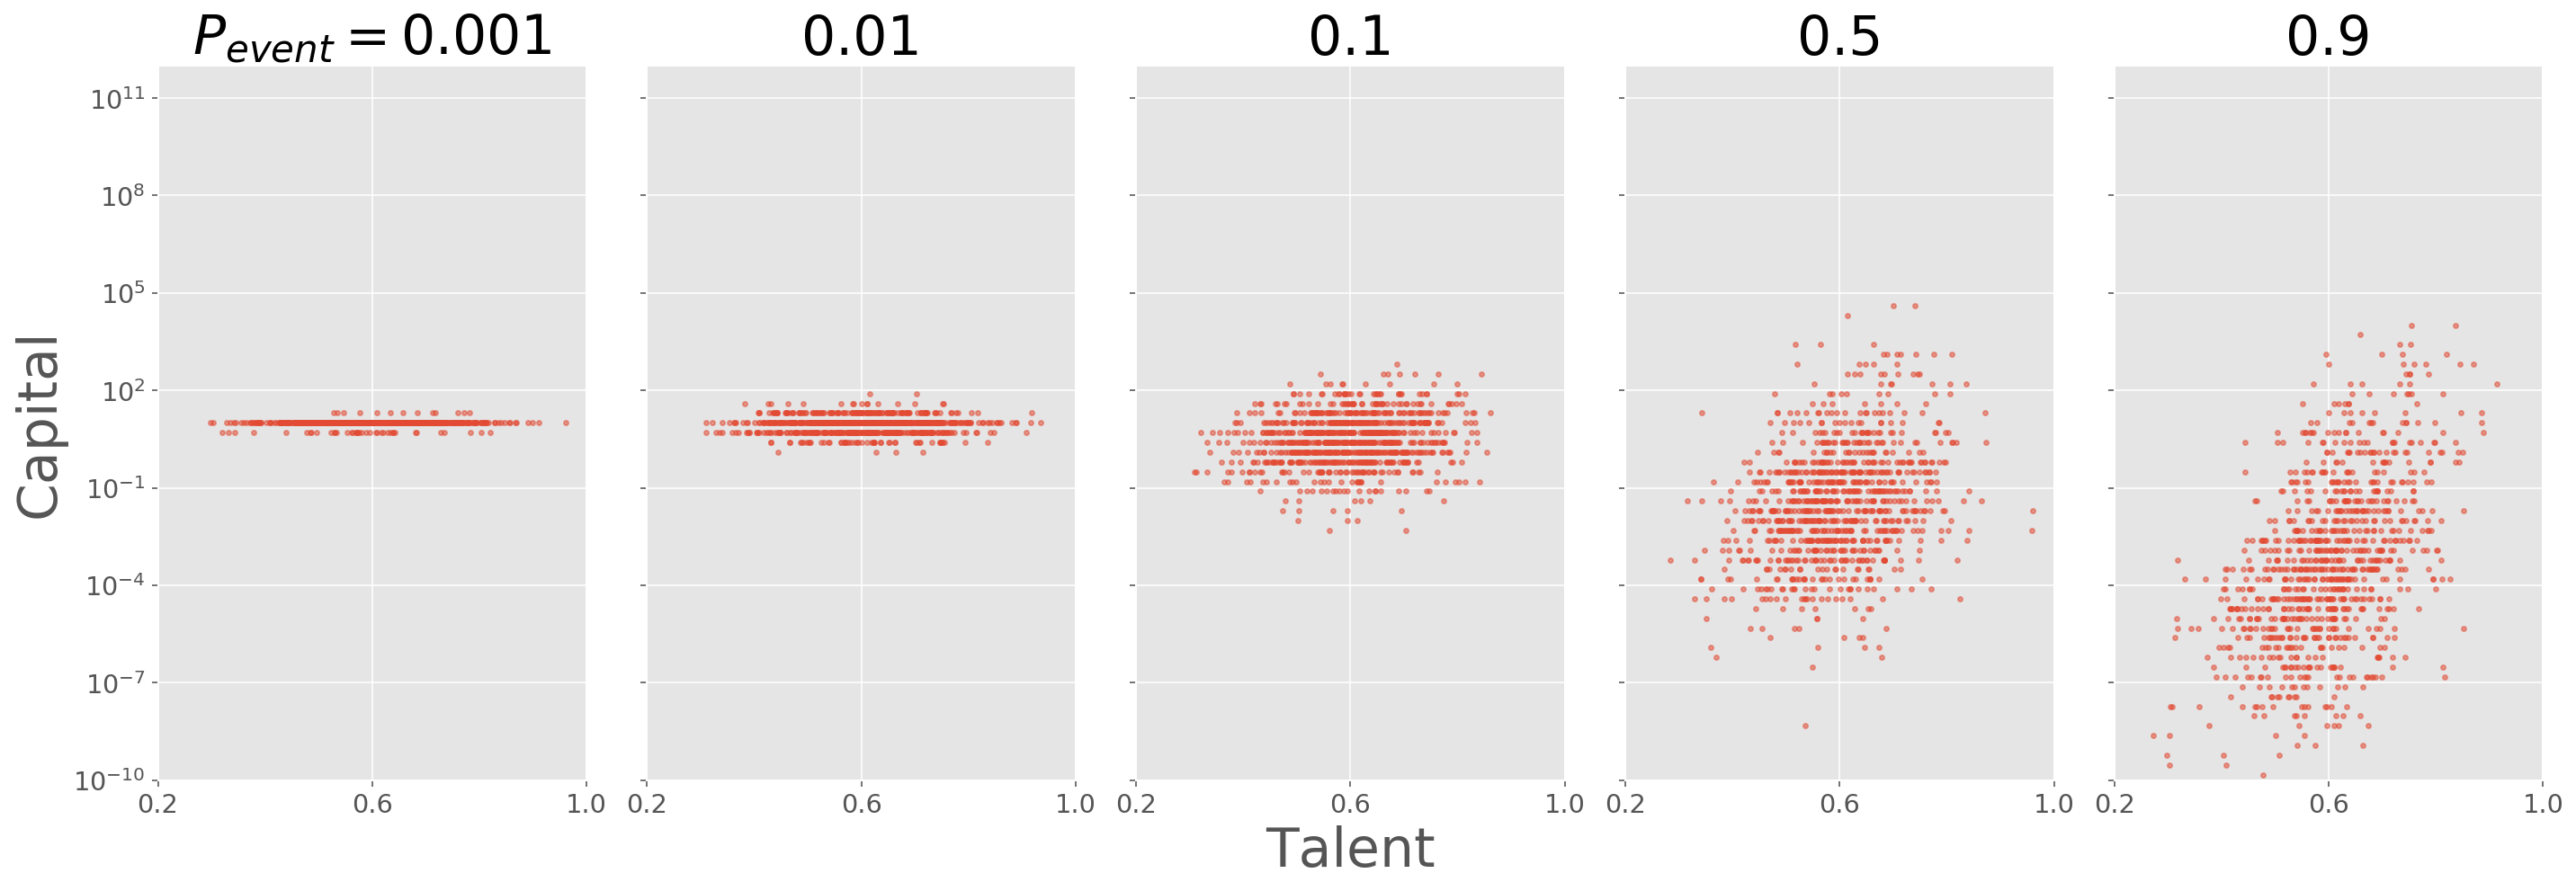

In [12]:
scatter_talent_capital_P_events(P_events, Cs_dict, Ts_dict, fname='Figures/P_event_original_model_unbalanced')

This figure shows how stochasticity is manifested in talent-capital relationship. $P_{event}=0.001$ means an event can happen at every 500 years and $P_{event}=0.9$ means an event can happen at about every 6 months.
- When $P_{event}$ is small, nothing really happens and everyone’s capital is more or less the same as the start amount ($C=10$).
- However, the more stochastic the world becomes (wider cloud of dots) , the more often our lives are bombarded by unpredictable lucky and unlucky events, which creates large economic inequality.
- With high stochasticity ($P_{event}>0.1$), talent becomes more useful because people have to be smart enough to profit from the lucky events. Therefore, we start seeing positive correlation in the high stochasticity settings, which means talent does matter in this setting.
- Also, with high stochasticity, more people fall into poverty because of the imbalance between the return of the lucky and unlucky events; unlucky events always punish individuals

# 4. The new model
I create a function `rum_sim_all` that incorporates all the scenarios mentioned above. Check `talent_v_luck.py` for details. Below is an example.

In [13]:
Cs, Ts, Cs_all, results_all = run_sim_all(P_event=0.1, w_Talent=0, use_default=True)

In [14]:
print(Cs.shape)
print(Ts.shape)
print(Cs_all.shape)
print(results_all.shape)

(1000,)
(1000,)
(81, 1000)
(81, 1000)


- `Cs`: A vector of the final capital values of all 1000 individuals 
- `Ts`: A vector of the talent values of all 1000 individuals (constant over time)
- `Cs_all`: A matrix of the history of capital values at every time step for the entire simulation run, for all 1000 individuals
- `results_all`: A matrix of the history of event values (1: lucky, 0: no event, -1: unlucky) at every time step for the entire simulation run, for all 1000 individuals

## 4.1 Visualization
## 4.1.1 Capital change over time and the timing of events
We can visualize the ups and downs of one's capital over time to take a deeper look at the relationship between the talent, luck and capital.

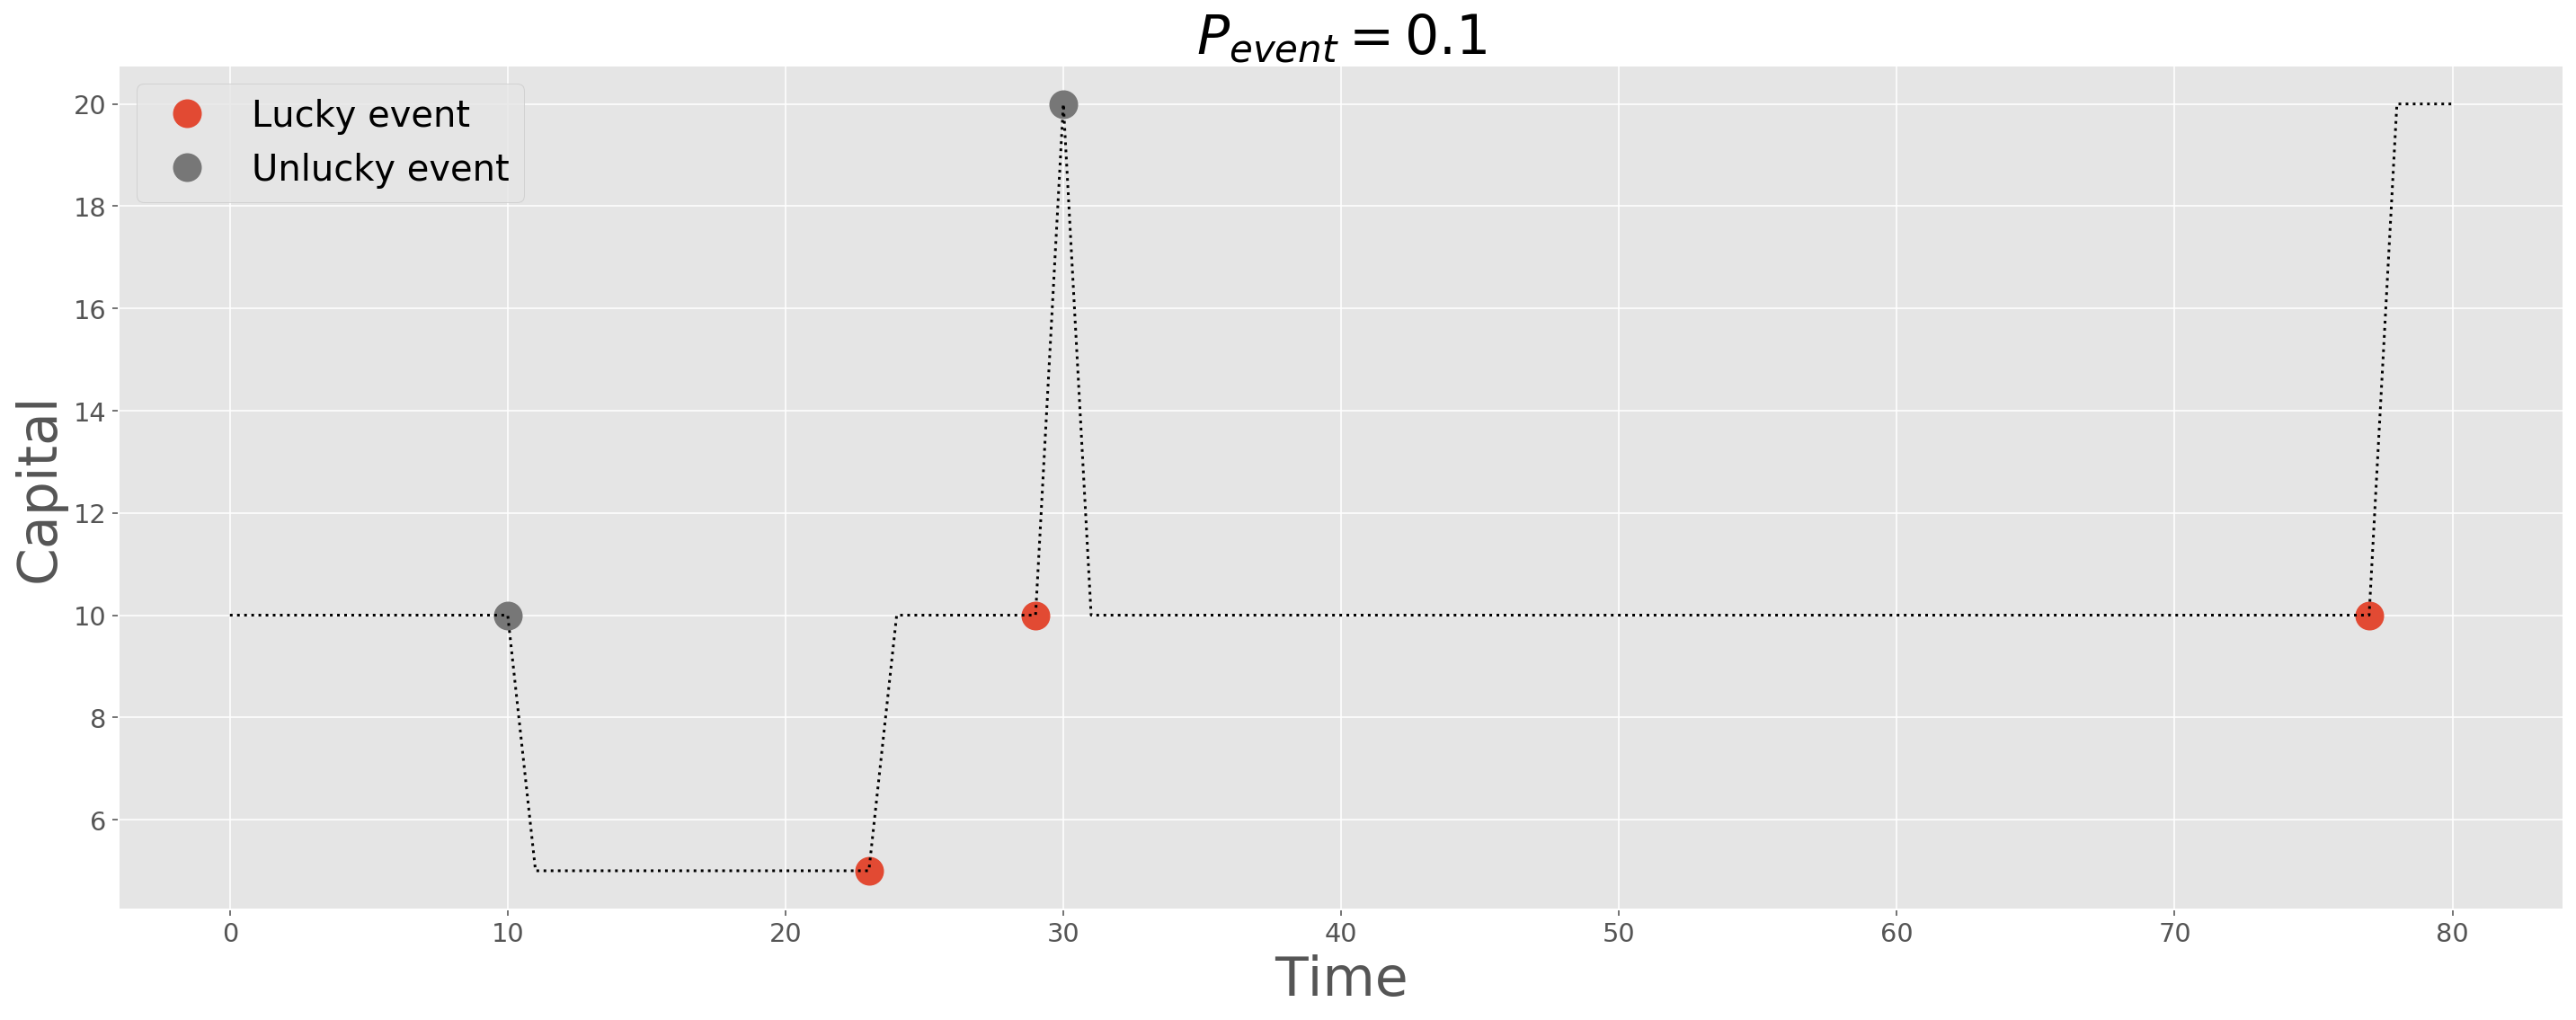

In [15]:
plot_C_over_t(Cs_all[:,0], results_all[:,0], s_title='$P_{event}=0.1$', 
              fname='Figures/capital_history_P_event_0.1', scale='linear')

# 5. Simulating various scenarios
## Scenario 1. Balanced unlucky events

In [16]:
P_events = [0.001, 0.01, 0.1, 0.5, 0.9]

In [17]:
Cs_dict_imbalanced = {}
Ts_dict_imbalanced = {}
Cs_dict_balanced = {}
Ts_dict_balanced = {}

for P_event in P_events:
    Cs_dict_imbalanced[P_event], Ts_dict_imbalanced[P_event] = run_sim(P_event, balanced=False)
    Cs_dict_balanced[P_event], Ts_dict_balanced[P_event], _, _ = run_sim_all(P_event=P_event, use_default=True, w_Talent=0)
    
data_groupA = {'C': Cs_dict_imbalanced, 'T': Ts_dict_imbalanced}
data_groupB = {'C': Cs_dict_balanced, 'T': Ts_dict_balanced}

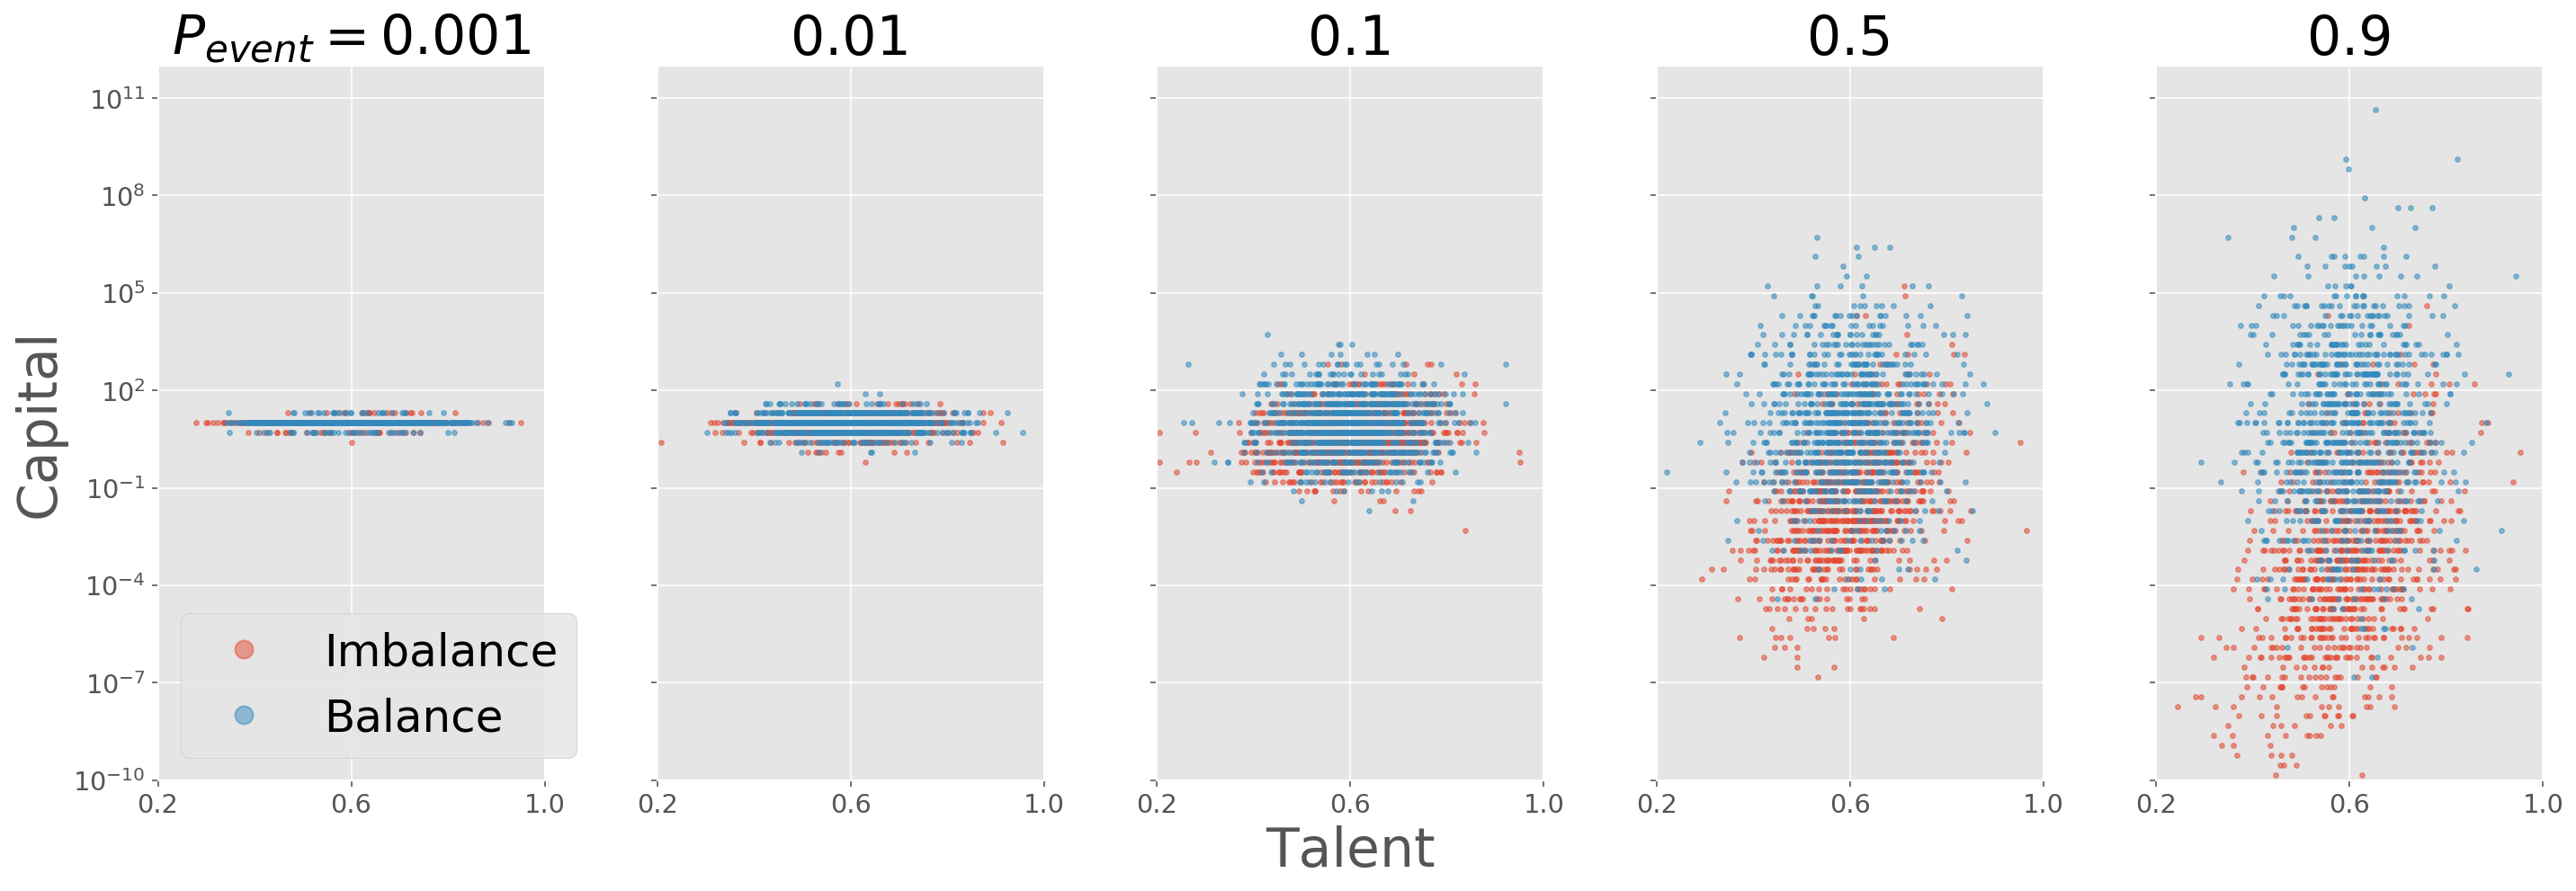

In [18]:
scatter_talent_capital_P_events_comparison(P_events, data_groupA, data_groupB, 
                                           labels={'A':'Imbalance', 'B':'Balance'}, 
                                           fname='Figures/P_events_S1_balanced_unlucky_events')

## Scenario 2. Talent directly affects the return of luck

In [19]:
Cs_dict_A = {} 
Ts_dict_A = {}
Cs_dict_B = {}
Ts_dict_B = {}

for P_event in P_events:
    # default
    Cs_dict_A[P_event], Ts_dict_A[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=0, use_default=True)
    # talent affects luck
    Cs_dict_B[P_event], Ts_dict_B[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=0, use_default=False)
    
data_groupA = {'C': Cs_dict_A, 'T': Ts_dict_A}
data_groupB = {'C': Cs_dict_B, 'T': Ts_dict_B}

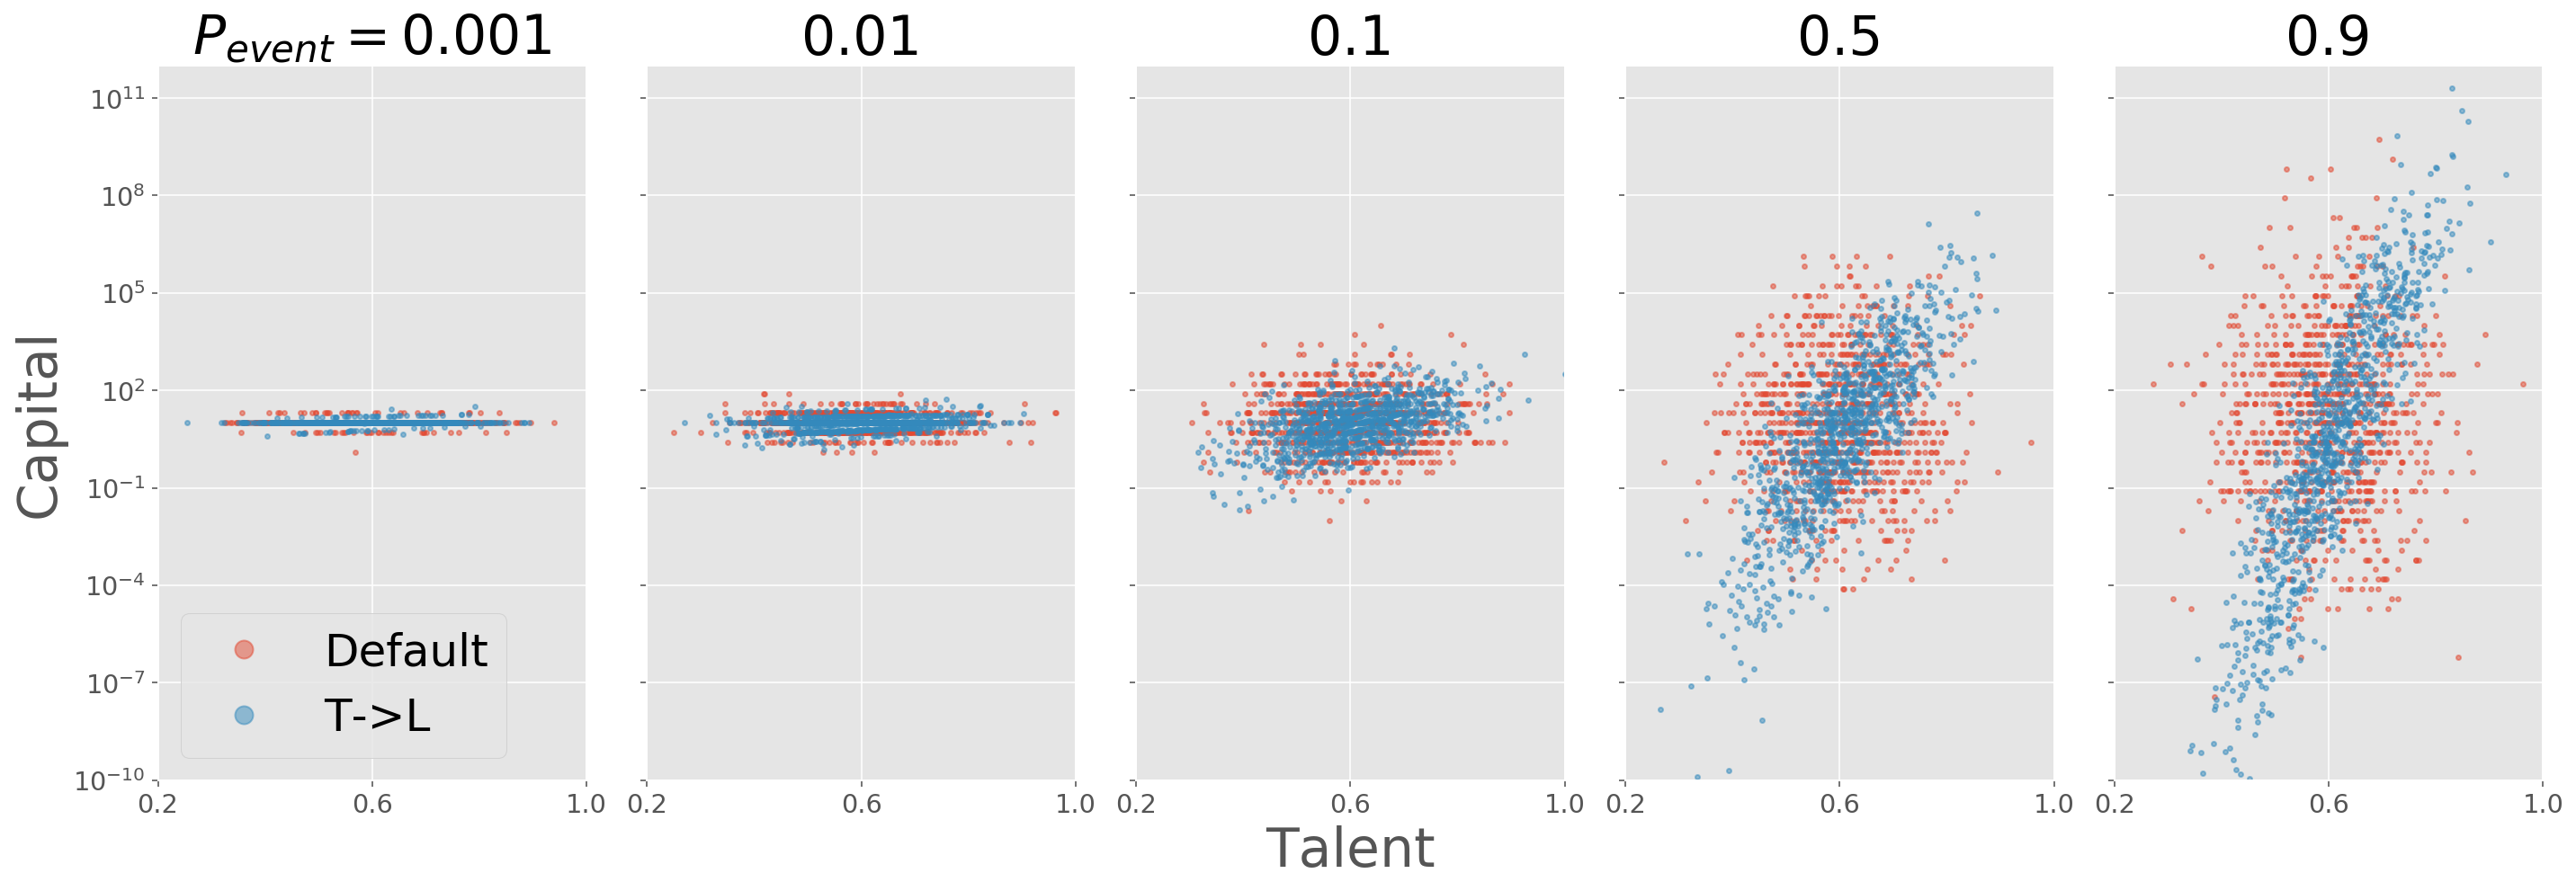

In [20]:
scatter_talent_capital_P_events_comparison(P_events, data_groupA, data_groupB, 
                                           labels={'A':'Default', 'B':'T->L'}, 
                                           fname='Figures/P_events_S2_talent_affects_luck')

## Scenario 3: Paycheck (“Hard work pays off”)

In [21]:
_, _, Cs_all, results_all = run_sim_all(P_event=0.1, w_Talent=1)

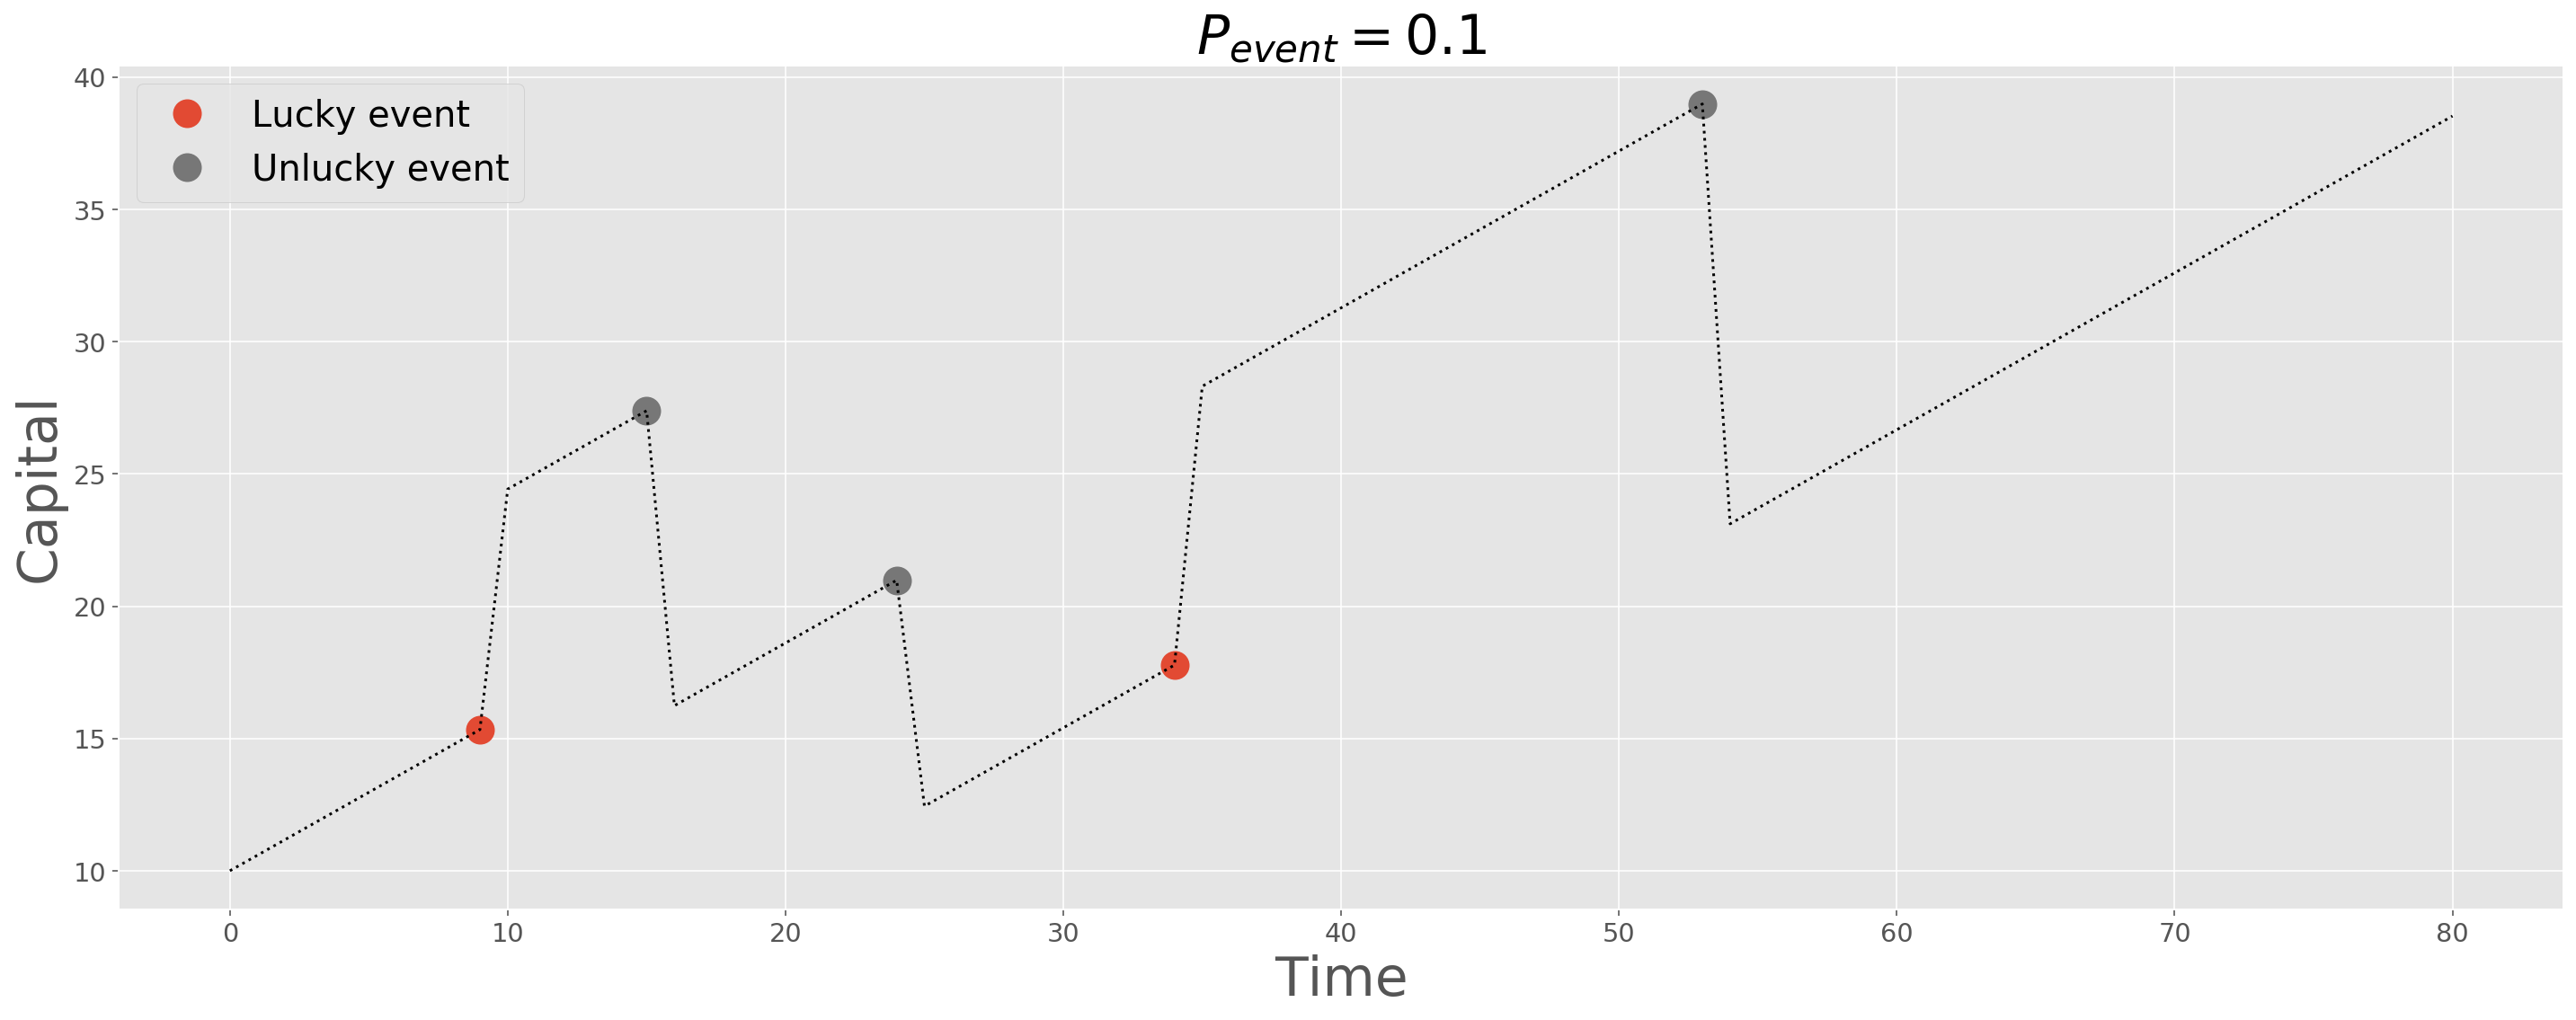

In [22]:
plot_C_over_t(Cs_all[:,0], results_all[:,0], s_title='$P_{event}=0.1$', 
              fname='Figures/capital_history_paycheck_P_event_0.1', scale='linear')

In [23]:
Cs_dict_A = {} 
Ts_dict_A = {}
Cs_dict_B = {}
Ts_dict_B = {}

for P_event in P_events:
    # no paycheck
    Cs_dict_A[P_event], Ts_dict_A[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=0)
    # paycheck
    Cs_dict_B[P_event], Ts_dict_B[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=1)
    
data_groupA = {'C': Cs_dict_A, 'T': Ts_dict_A}
data_groupB = {'C': Cs_dict_B, 'T': Ts_dict_B}

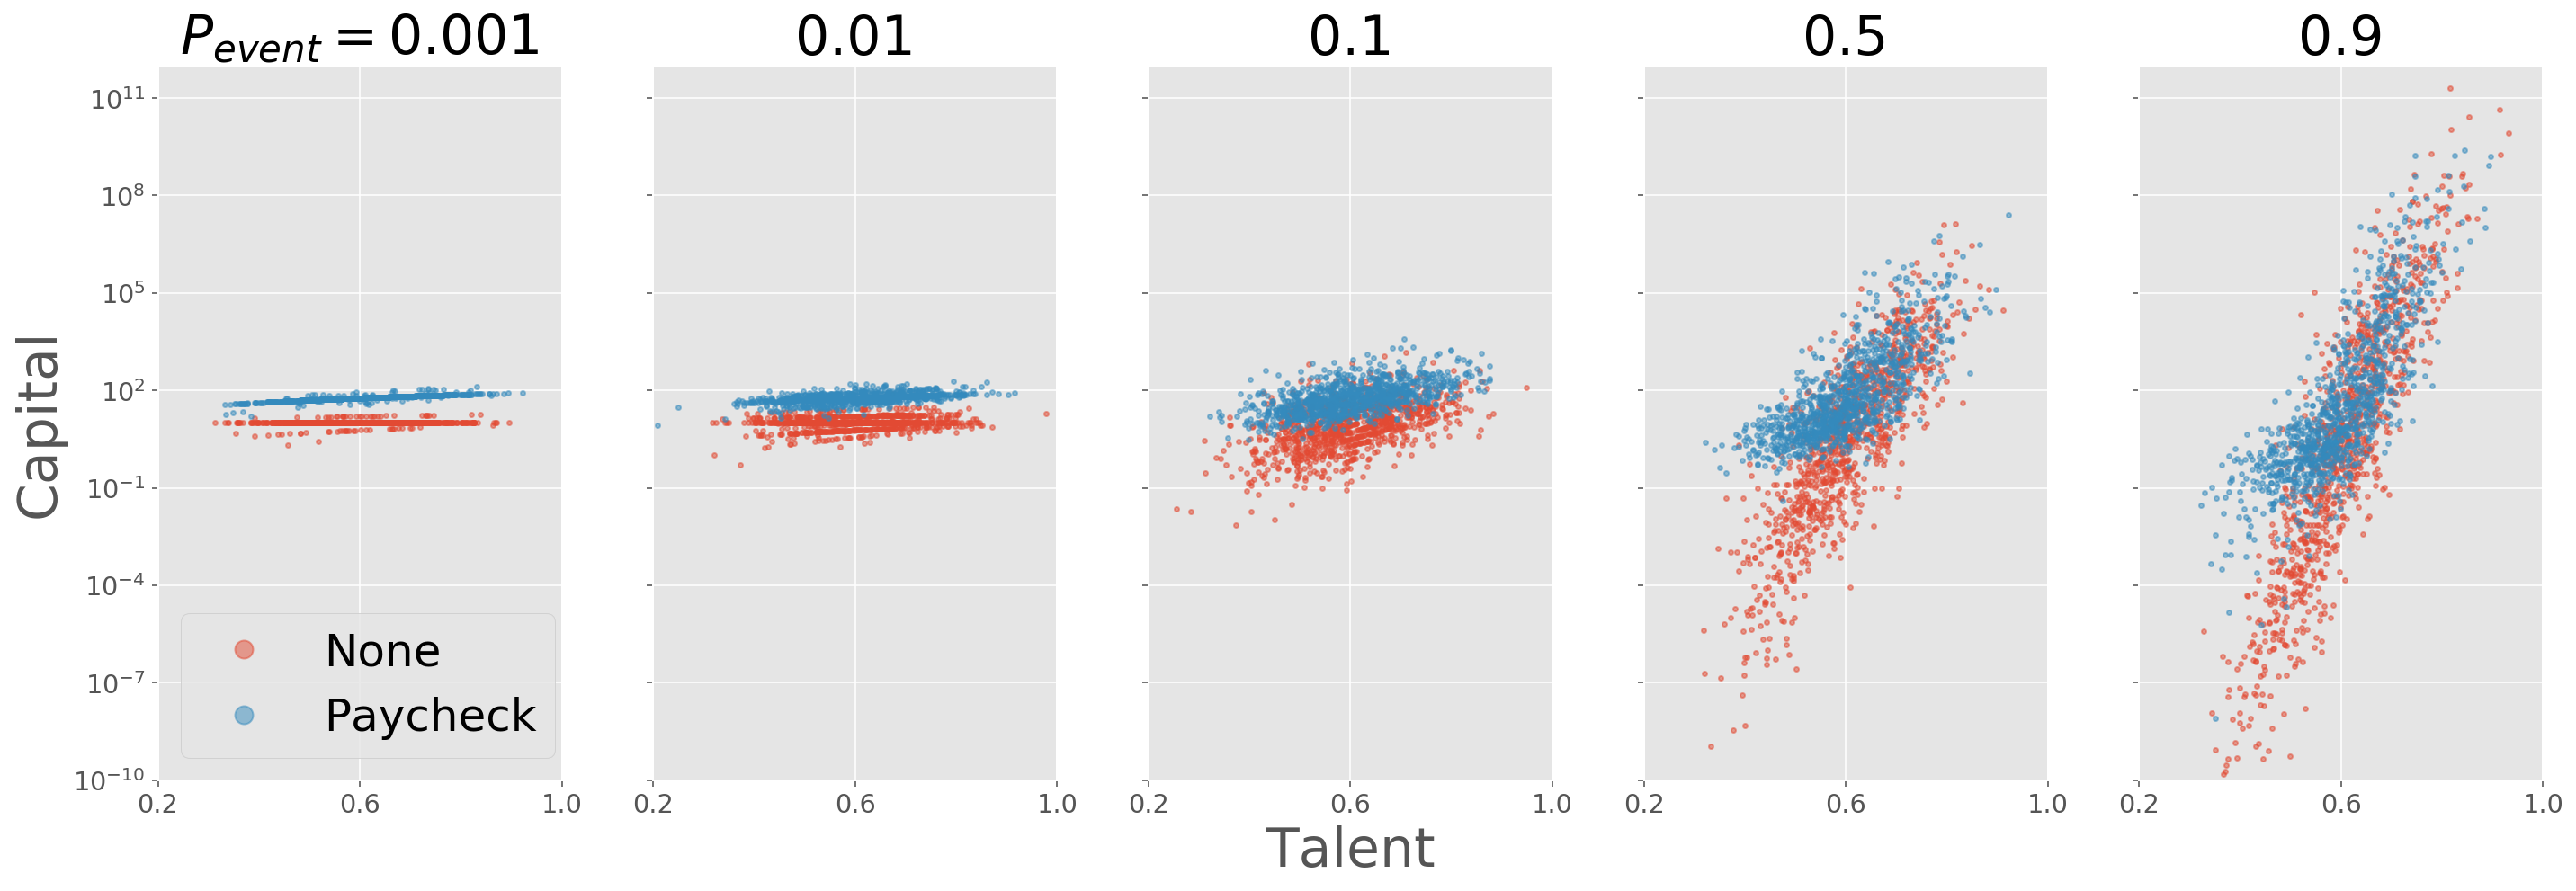

In [24]:
scatter_talent_capital_P_events_comparison(P_events, data_groupA, data_groupB, 
                                           labels={'A':'None', 'B':'Paycheck'}, 
                                           fname='Figures/P_events_S3_hard_work_pays_off')

### Paycheck and inequality
$P_{event} = 0.1$

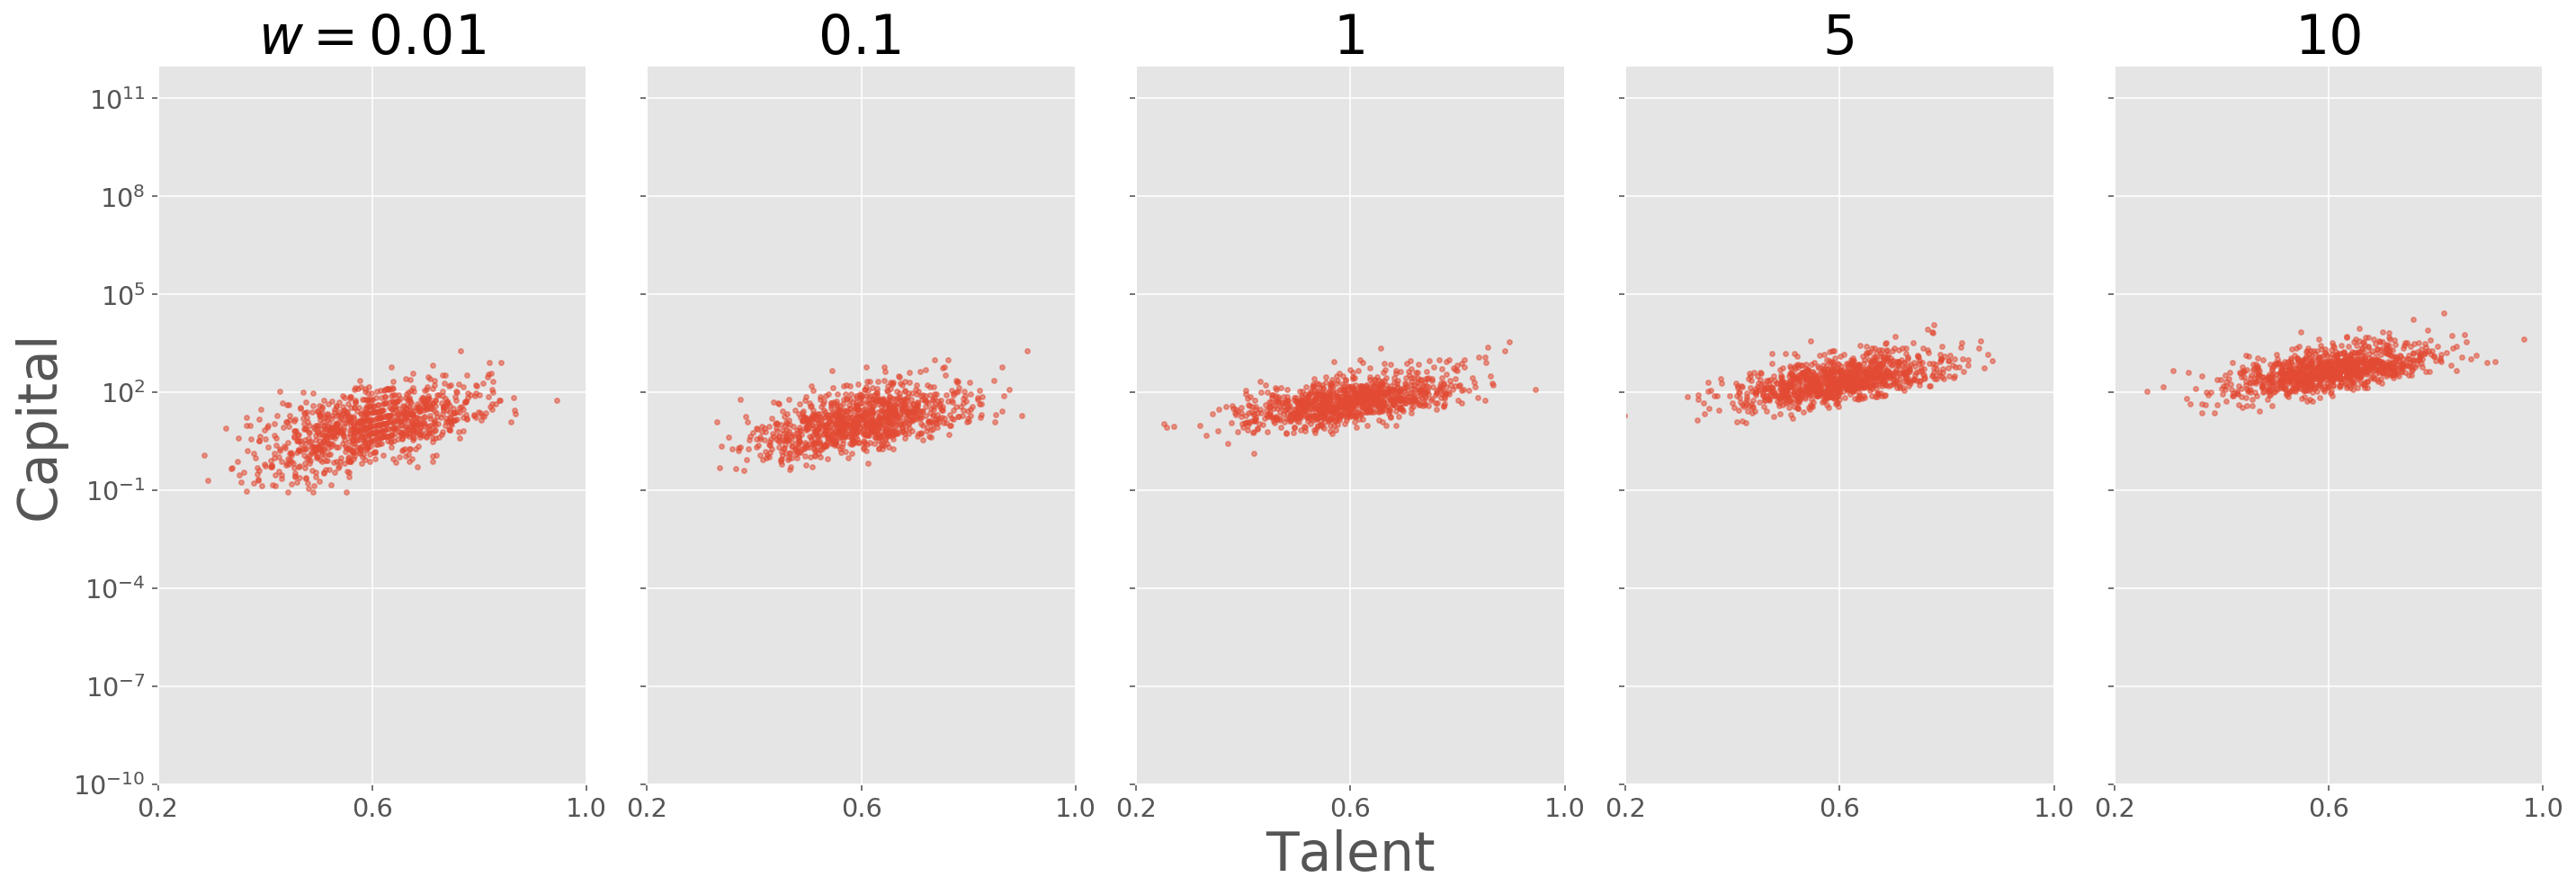

In [25]:
w_Talents = [0.01, 0.1, 1, 5, 10]

fig, axes = plt.subplots(1, len(w_Talents), sharey=True, figsize=(20,7))
for i, (w_Talent, ax) in enumerate(zip(w_Talents, axes)):
    
    Cs, Ts, _, _ = run_sim_all(P_event=0.1, w_Talent=w_Talent)
    
    ax.plot(Ts, Cs, '.', alpha=0.5, markersize=5)
    ax.set_xlim(0.2, 1)
    ax.set_ylim(10e-11, 10e11)
    ax.set_xticks([0.2, 0.6, 1])
    ax.set_yscale('log')
    if i == 0:
        ax.set_title('$w=$'+str(w_Talent), fontsize=30)
    else:
        ax.set_title(str(w_Talent), fontsize=30)
    if i == 0:
        ax.set_ylabel('Capital', fontsize=30)
    if i == 2:
        ax.set_xlabel('Talent', fontsize=30)
    ax.tick_params(labelsize='x-large')

plt.tight_layout()
plt.savefig('Figures/S3_paycheck_effect_varying_w_P_event_0.1.png')
plt.show();

## Scenario 4: Interest rate

### Interest rate without paycheck

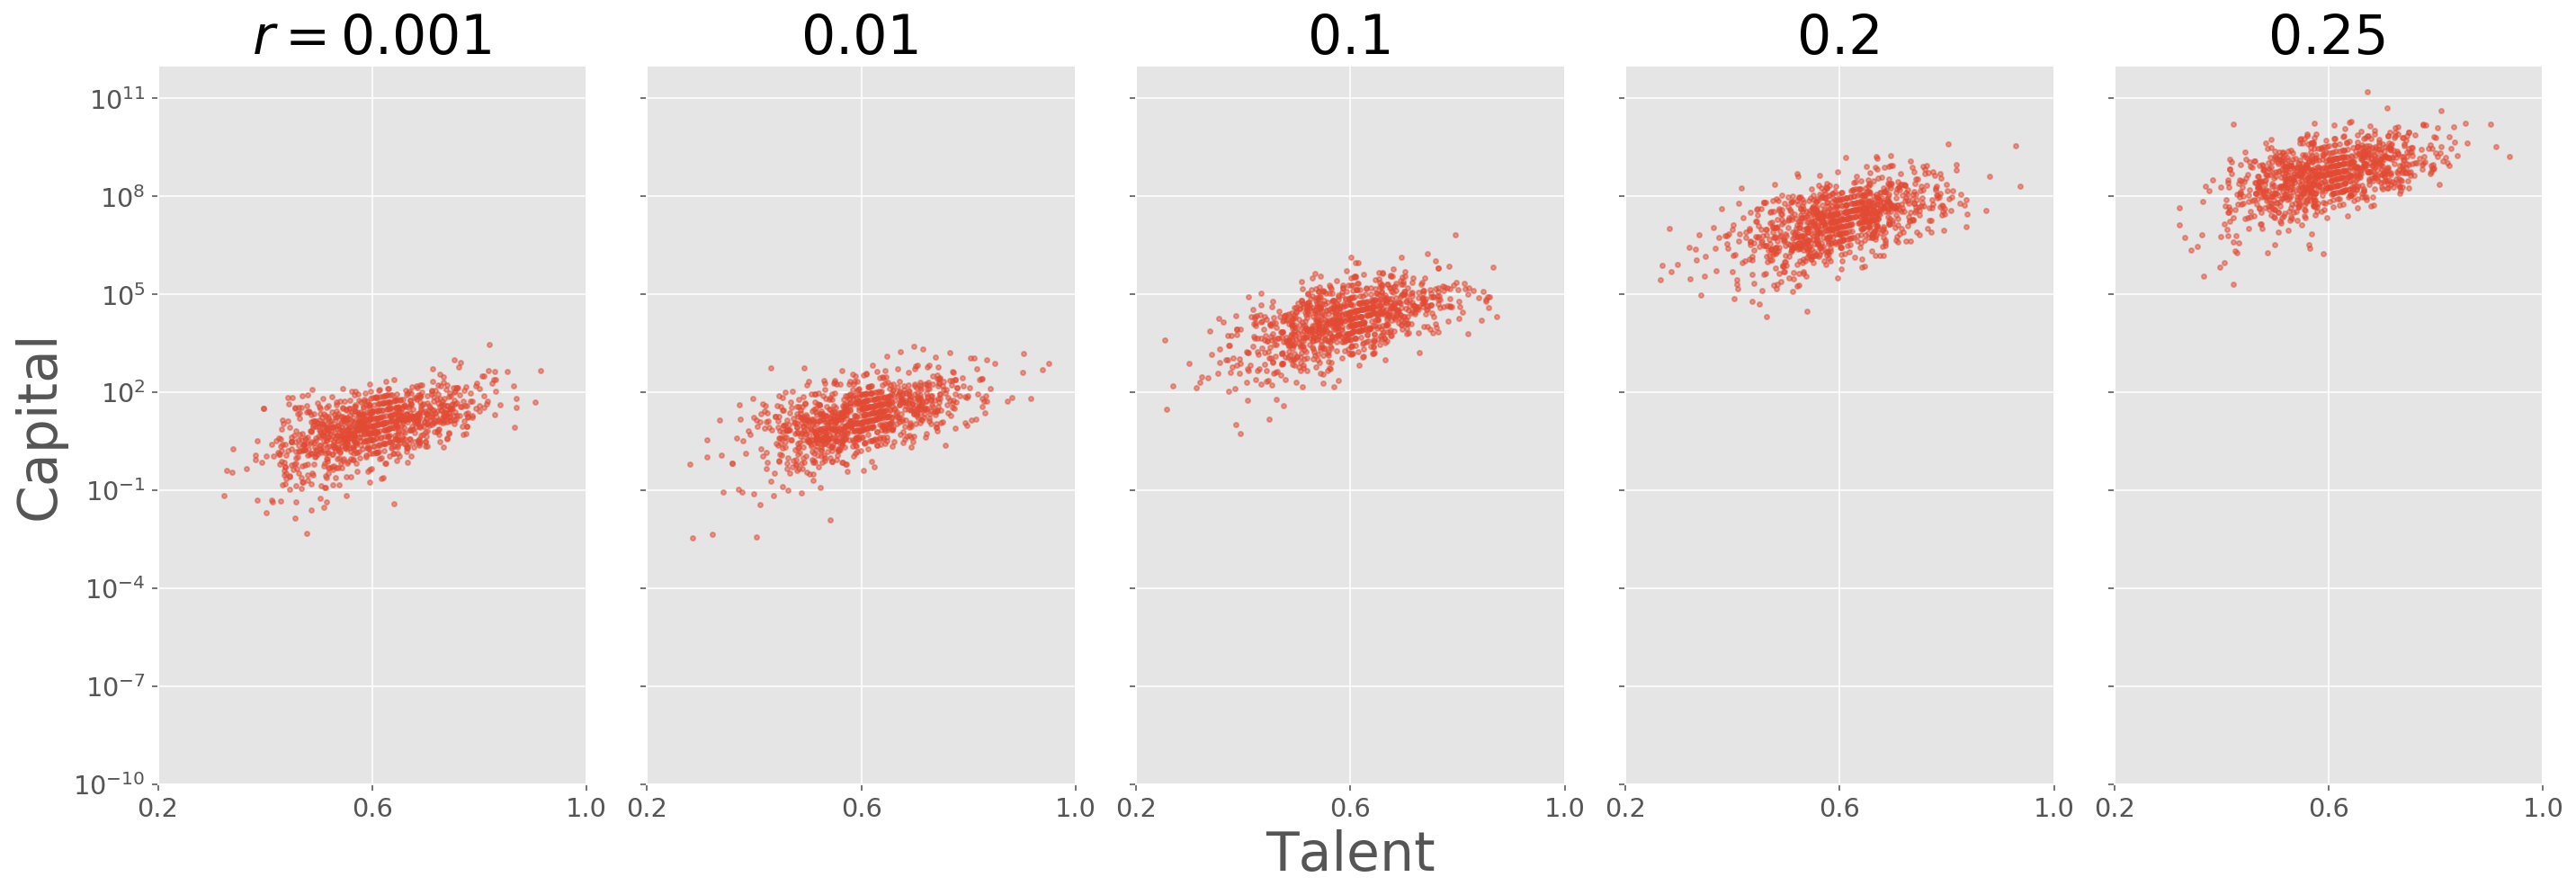

In [26]:
interest_rates = [0.001, 0.01, 0.1, 0.2, 0.25]

fig, axes = plt.subplots(1, len(interest_rates), sharey=True, figsize=(20,7))
for i, (interest_rate, ax) in enumerate(zip(interest_rates, axes)):
    
    Cs, Ts, _, _ = run_sim_all(P_event=0.1, w_Talent=0, interest_rate=interest_rate)
    
    ax.plot(Ts, Cs, '.', alpha=0.5, markersize=5)
    ax.set_xlim(0.2, 1)
    ax.set_ylim(10e-11, 10e11)
    ax.set_xticks([0.2, 0.6, 1])
    ax.set_yscale('log')
    if i == 0:
        ax.set_title('$r=$'+str(interest_rate), fontsize=30)
    else:
        ax.set_title(str(interest_rate), fontsize=30)
    if i == 0:
        ax.set_ylabel('Capital', fontsize=30)
    if i == 2:
        ax.set_xlabel('Talent', fontsize=30)
    ax.tick_params(labelsize='x-large')

plt.tight_layout()
plt.savefig('Figures/S4_interest_without_paycheck_P_event_0.1.png')
plt.show();

### Interest rate with paycheck

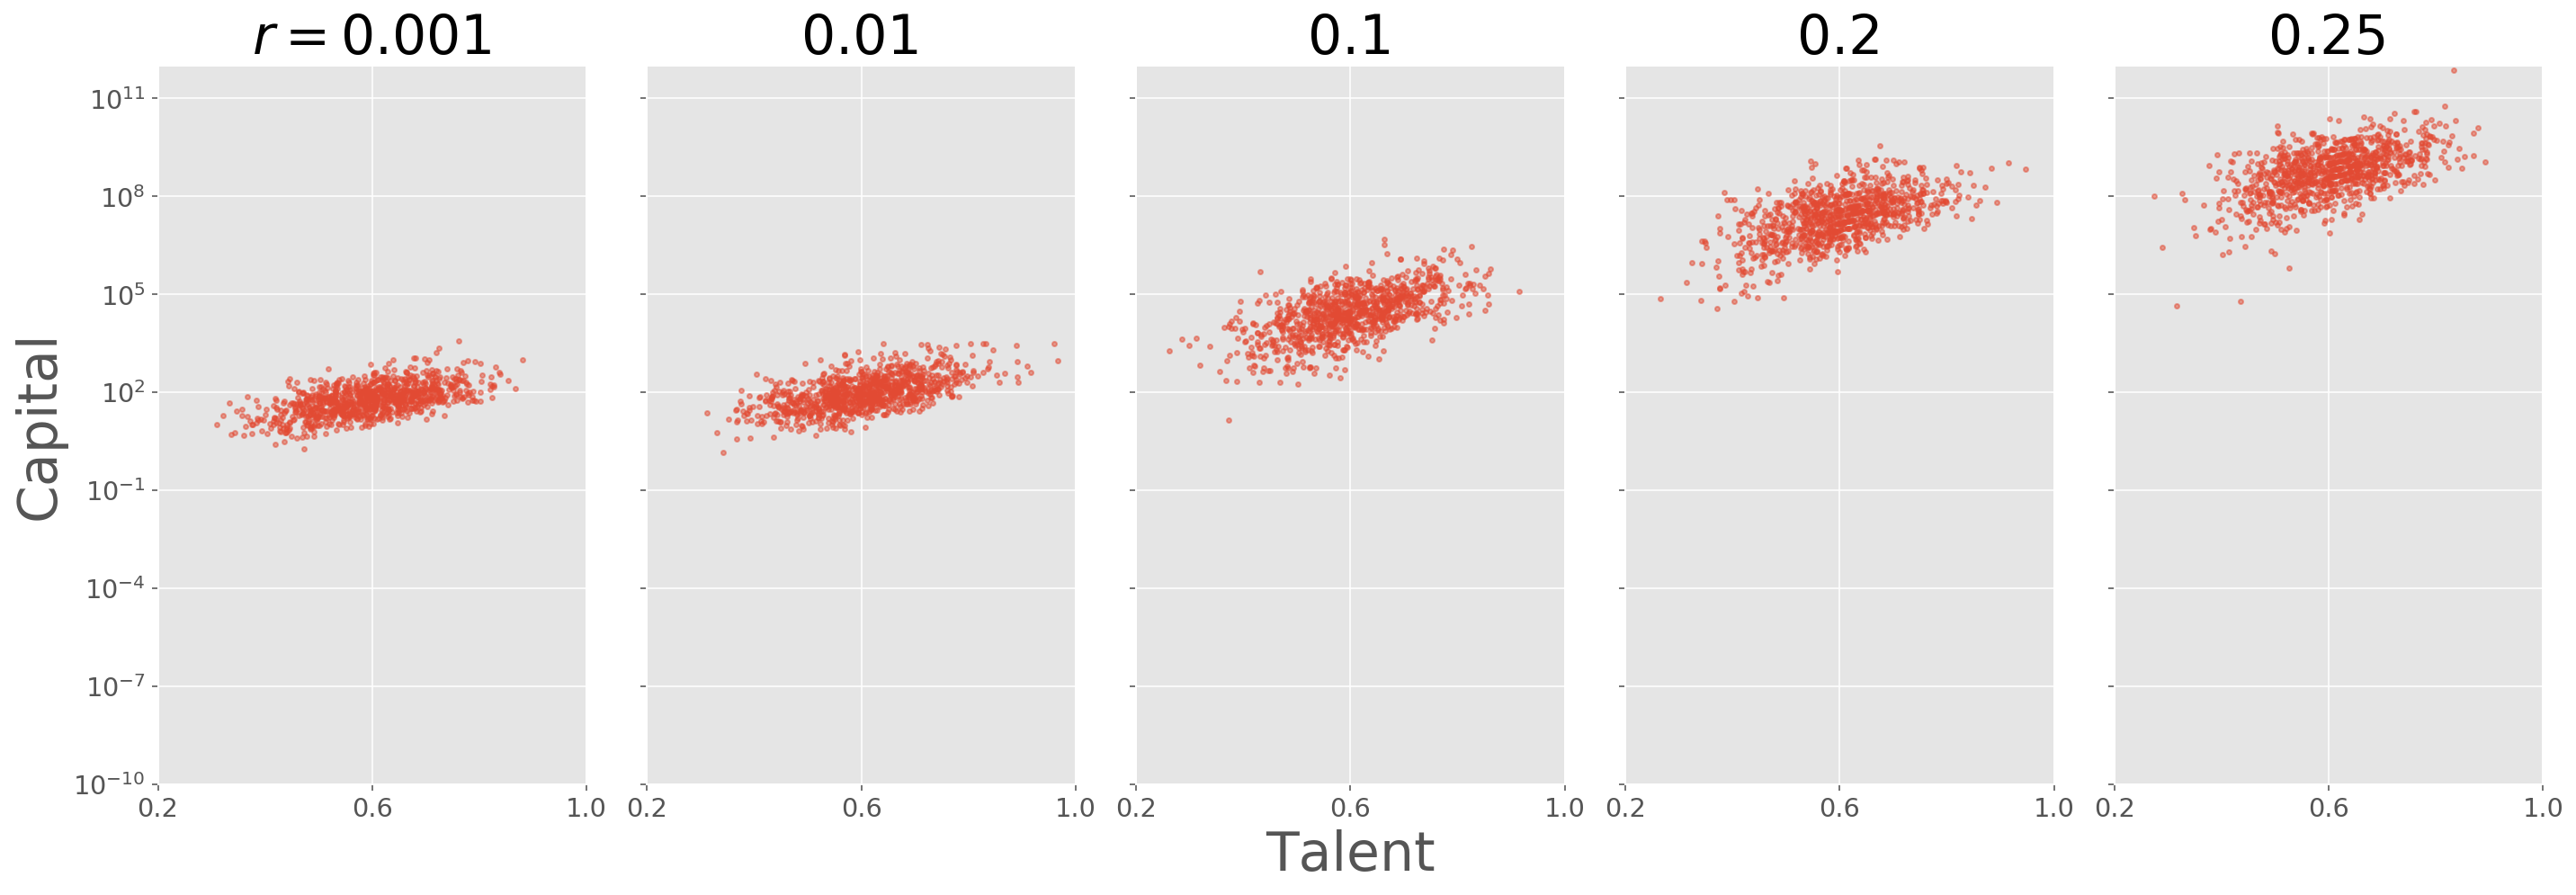

In [27]:
interest_rates = [0.001, 0.01, 0.1, 0.2, 0.25]

fig, axes = plt.subplots(1, len(interest_rates), sharey=True, figsize=(20,7))
for i, (interest_rate, ax) in enumerate(zip(interest_rates, axes)):
    
    Cs, Ts, _, _ = run_sim_all(P_event=0.1, w_Talent=1, interest_rate=interest_rate)
    
    ax.plot(Ts, Cs, '.', alpha=0.5, markersize=5)
    ax.set_xlim(0.2, 1)
    ax.set_ylim(10e-11, 10e11)
    ax.set_xticks([0.2, 0.6, 1])
    ax.set_yscale('log')
    if i == 0:
        ax.set_title('$r=$'+str(interest_rate), fontsize=30)
    else:
        ax.set_title(str(interest_rate), fontsize=30)
    if i == 0:
        ax.set_ylabel('Capital', fontsize=30)
    if i == 2:
        ax.set_xlabel('Talent', fontsize=30)
    ax.tick_params(labelsize='x-large')

plt.tight_layout()
plt.savefig('Figures/S4_interest_with_paycheck_P_event_0.1.png')
plt.show();

### Interest vs. no interest (with paycheck)

In [28]:
Cs_dict_A = {} 
Ts_dict_A = {}
Cs_dict_B = {}
Ts_dict_B = {}

for P_event in P_events:
    # no interest
    Cs_dict_A[P_event], Ts_dict_A[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=1, interest_rate=0)
    # interest
    Cs_dict_B[P_event], Ts_dict_B[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=1, interest_rate=0.1)
    
data_groupA = {'C': Cs_dict_A, 'T': Ts_dict_A}
data_groupB = {'C': Cs_dict_B, 'T': Ts_dict_B}

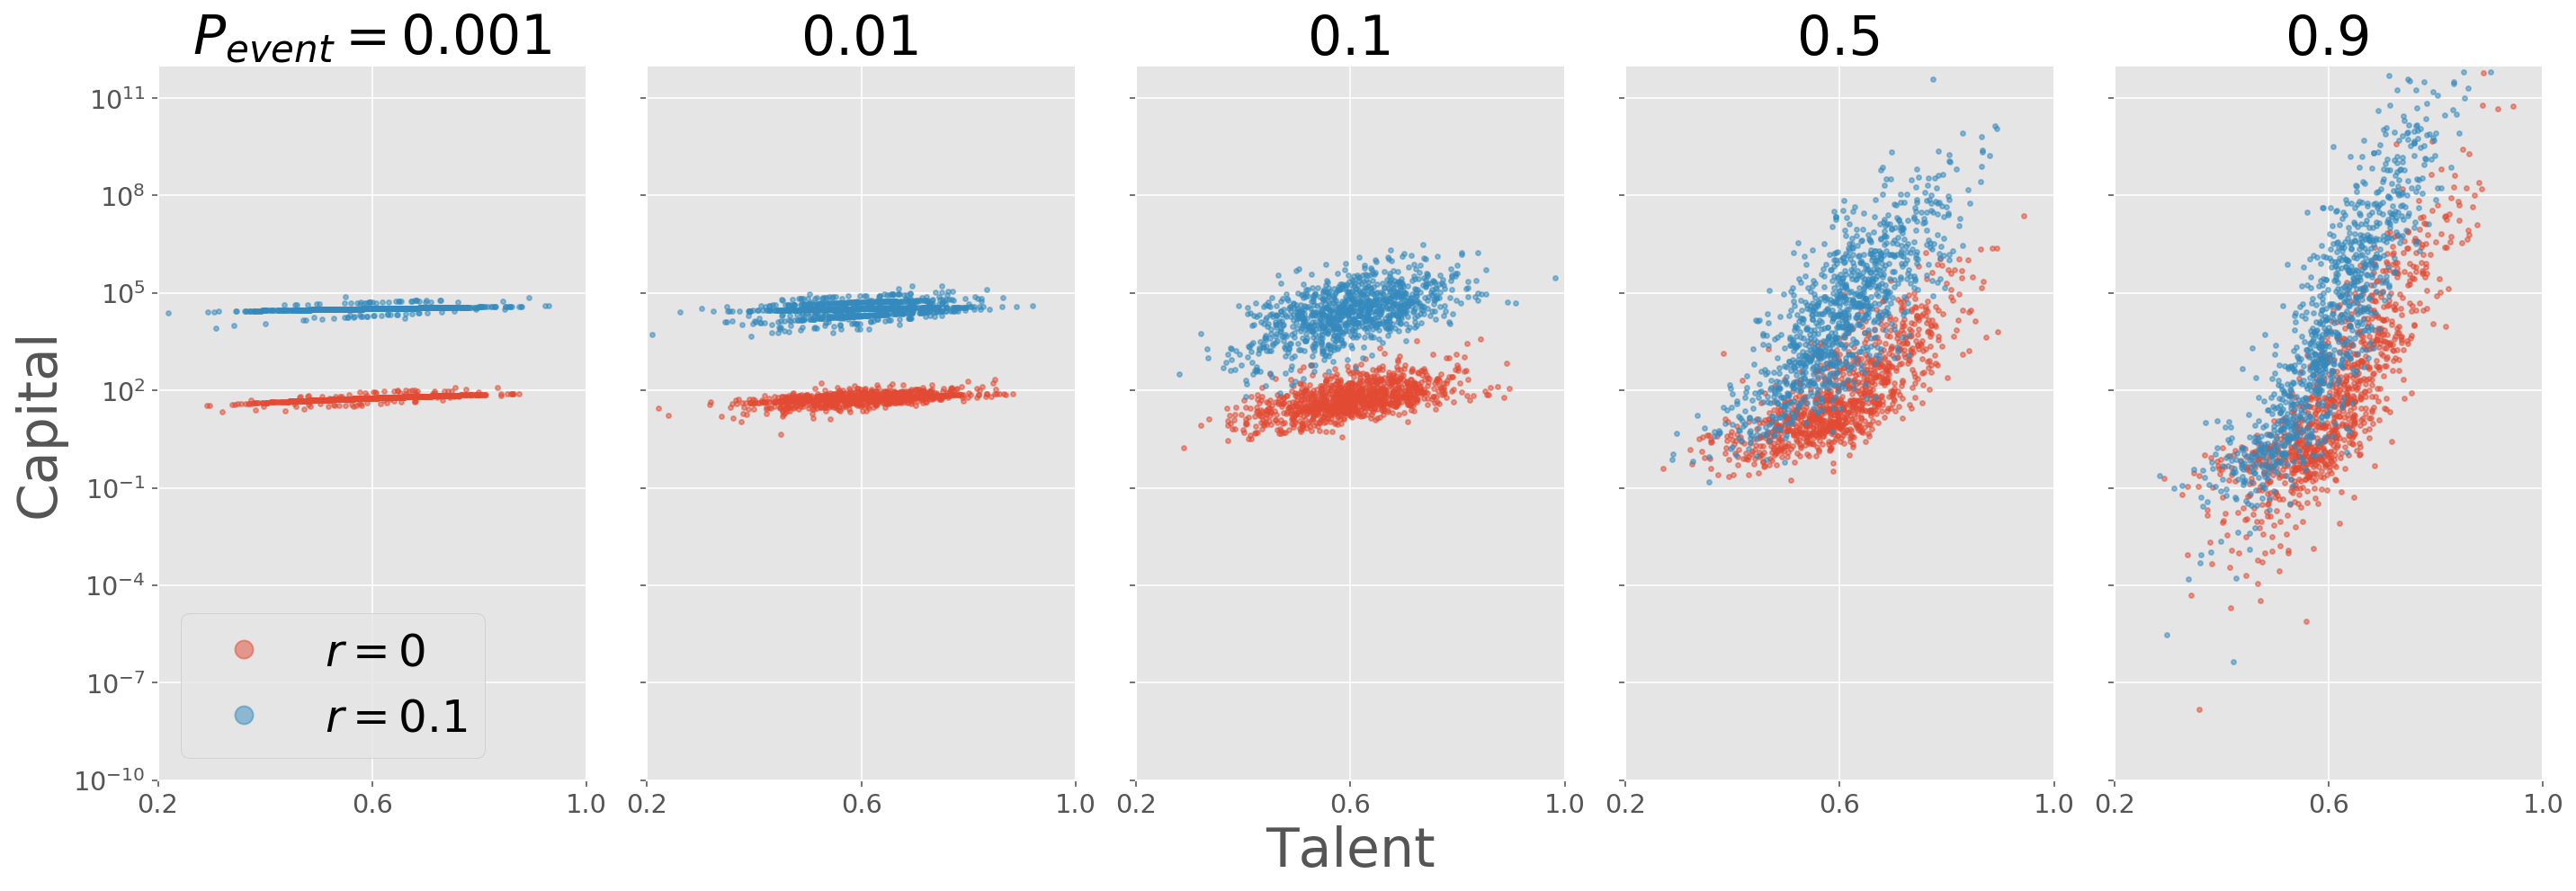

In [29]:
scatter_talent_capital_P_events_comparison(P_events, data_groupA, data_groupB, 
                                           labels={'A':'$r=0$', 'B':'$r=0.1$'}, 
                                           fname='Figures/P_events_S4_interest_v_none')

## Scenario 5: “The rich get luckier, the poor get unluckier”

### Default (equal luck) vs. The rich get luckier
People get paycheck and interest rate of 0.1 exists.

In [30]:
Cs_dict_A = {} 
Ts_dict_A = {}
Cs_dict_B = {}
Ts_dict_B = {}

for P_event in P_events:
    # default
    Cs_dict_A[P_event], Ts_dict_A[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=1, interest_rate=0.1)
    # rich get luckier
    Cs_dict_B[P_event], Ts_dict_B[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=1, interest_rate=0.1, turn_on_rich=True)
    
data_groupA = {'C': Cs_dict_A, 'T': Ts_dict_A}
data_groupB = {'C': Cs_dict_B, 'T': Ts_dict_B}

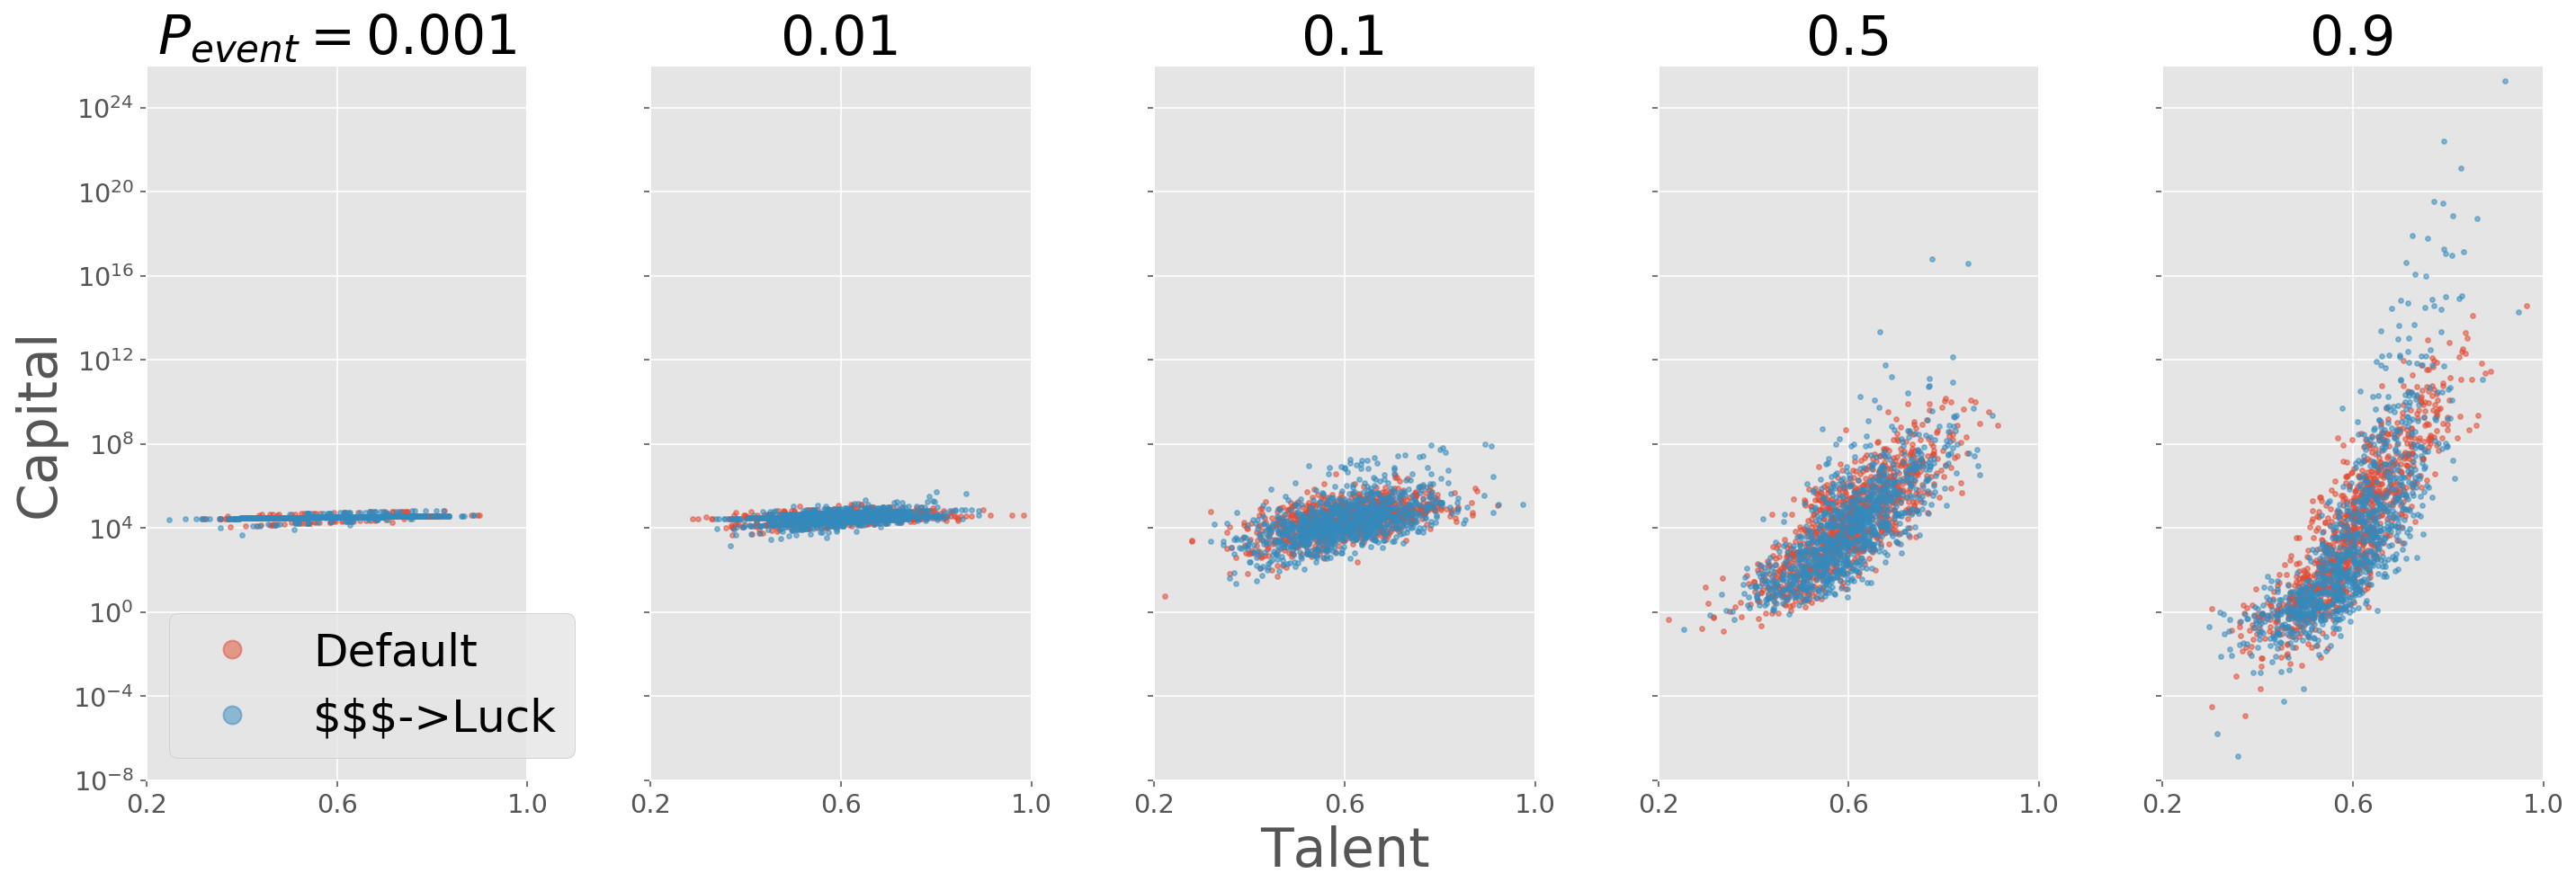

In [31]:
scatter_talent_capital_P_events_comparison(P_events, data_groupA, data_groupB, ylim=[10e-9, 10e25],
                                           labels={'A':'Default', 'B':'$$$->Luck'}, 
                                           fname='Figures/P_events_S5_default_vs_rich_lucky')

### The rich get luckier, without paycheck

In [32]:
Cs_dict = {}
Ts_dict = {}
for P_event in P_events:
    Cs_dict[P_event], Ts_dict[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=0, interest_rate=0.1, turn_on_rich=True)

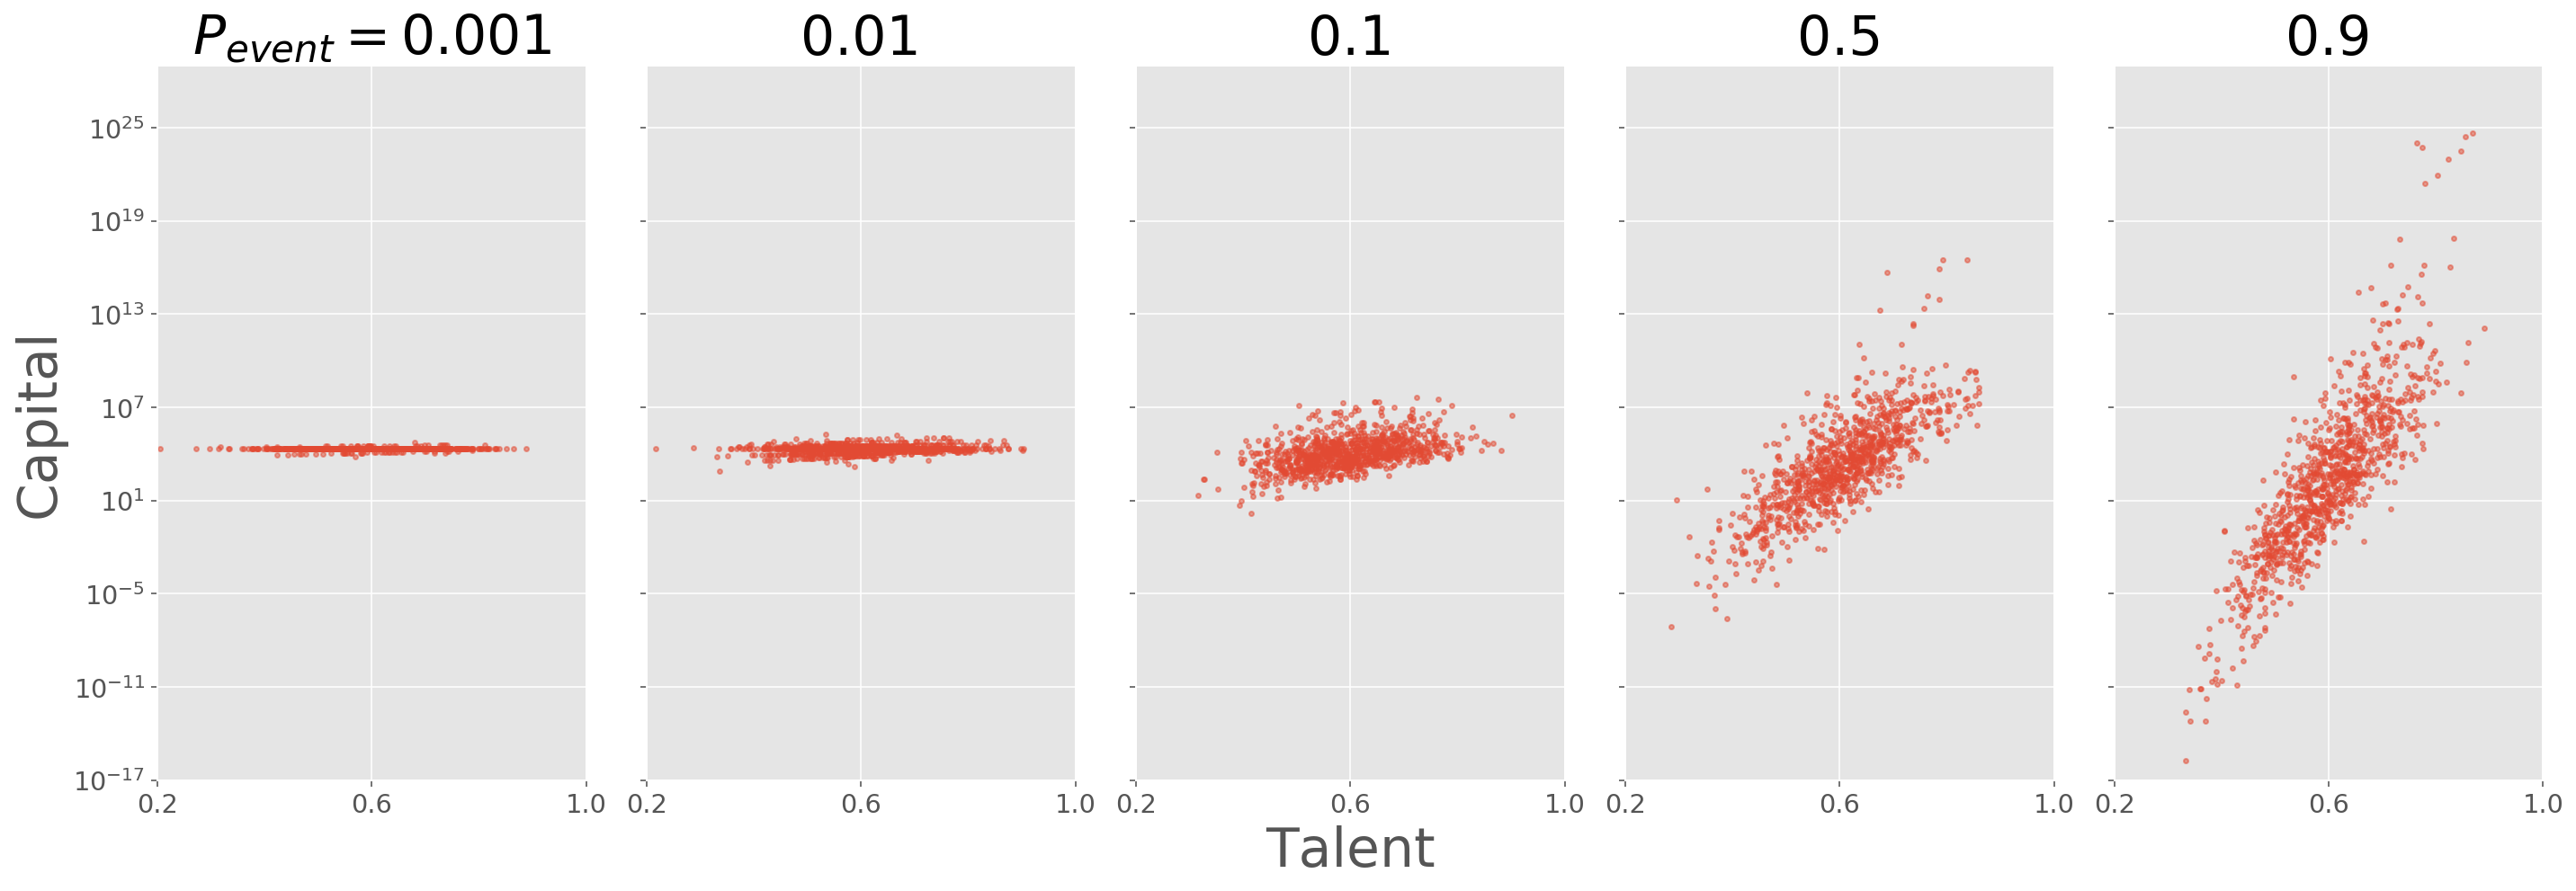

In [33]:
scatter_talent_capital_P_events(P_events, Cs_dict, Ts_dict, ylim=[10e-18, 10e28], 
                                fname='Figures/P_events_S5_rich_lucky_no_paycheck')

## Scenario 6: Income tax

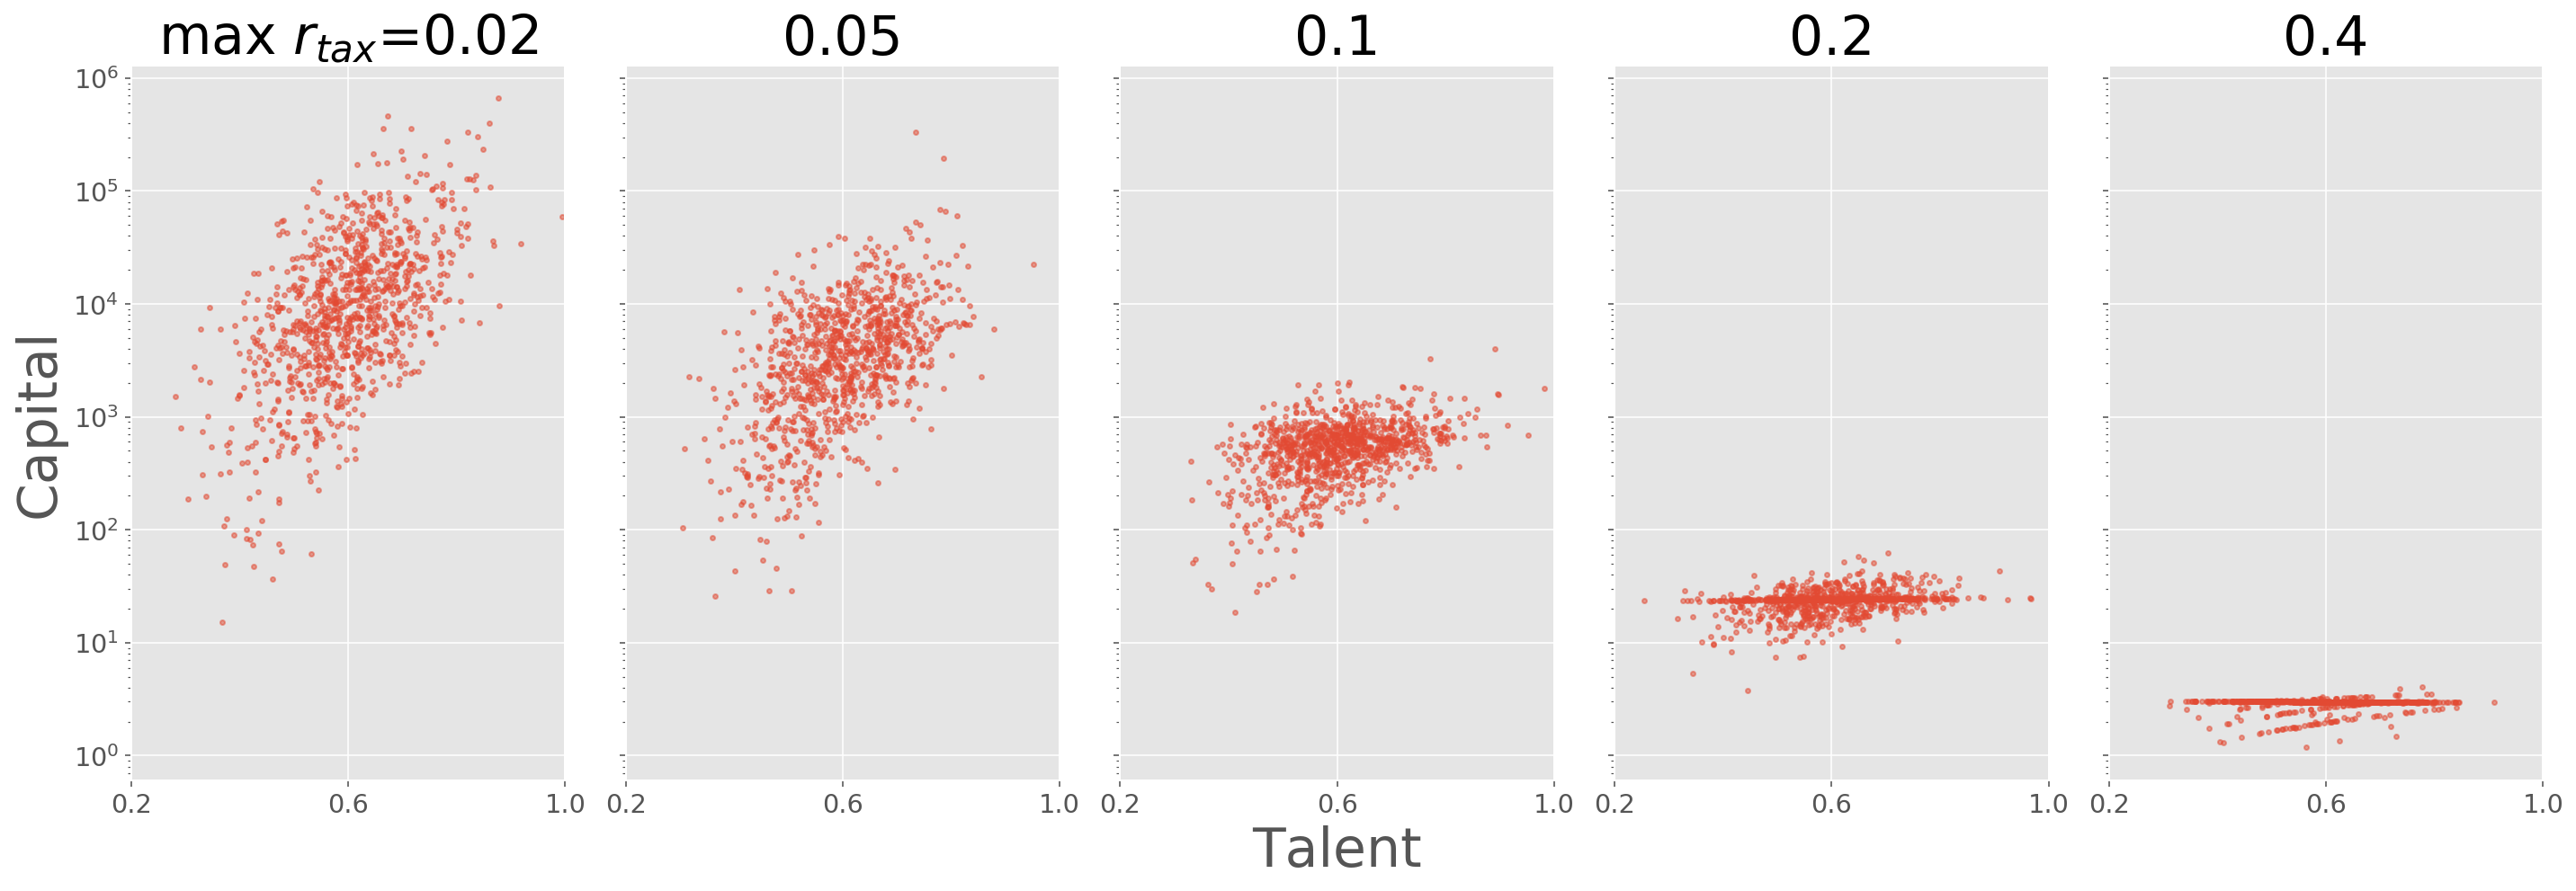

In [34]:
max_tax_rates = [0.02, 0.05, 0.1, 0.2, 0.4]
min_tax_rate = 0.01

fig, axes = plt.subplots(1, len(max_tax_rates), sharey=True, figsize=(20,7))
for i, (max_tax_rate, ax) in enumerate(zip(max_tax_rates, axes)):
    
    Cs, Ts, _, _ = run_sim_all(P_event=0.1, w_Talent=1, interest_rate=0.1,
                               max_tax_rate=max_tax_rate, min_tax_rate=min_tax_rate,
                               turn_on_tax=True)
    
    ax.plot(Ts, Cs, '.', alpha=0.5, markersize=5)
    ax.set_xlim(0.2, 1)
#     ax.set_ylim(10e-11, 10e11)
    ax.set_xticks([0.2, 0.6, 1])
    ax.set_yscale('log')
    if i == 0:
        ax.set_title('max $r_{tax}$='+str(max_tax_rate), fontsize=30)
    else:
        ax.set_title(str(max_tax_rate), fontsize=30)
    if i == 0:
        ax.set_ylabel('Capital', fontsize=30)
    if i == 2:
        ax.set_xlabel('Talent', fontsize=30)
    ax.tick_params(labelsize='x-large')

plt.tight_layout()
plt.savefig('Figures/S6_effect_tax.png')
plt.show();

## Scenario 7: Social safety net

In [35]:
Cs_dict_A = {} 
Ts_dict_A = {}
Cs_dict_B = {}
Ts_dict_B = {}

for P_event in P_events:
    # default
    Cs_dict_A[P_event], Ts_dict_A[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=1, interest_rate=0.1)
    # safety net
    Cs_dict_B[P_event], Ts_dict_B[P_event], _, _ = run_sim_all(P_event=P_event, w_Talent=1, interest_rate=0.1, turn_on_safenet=True)
    
data_groupA = {'C': Cs_dict_A, 'T': Ts_dict_A}
data_groupB = {'C': Cs_dict_B, 'T': Ts_dict_B}

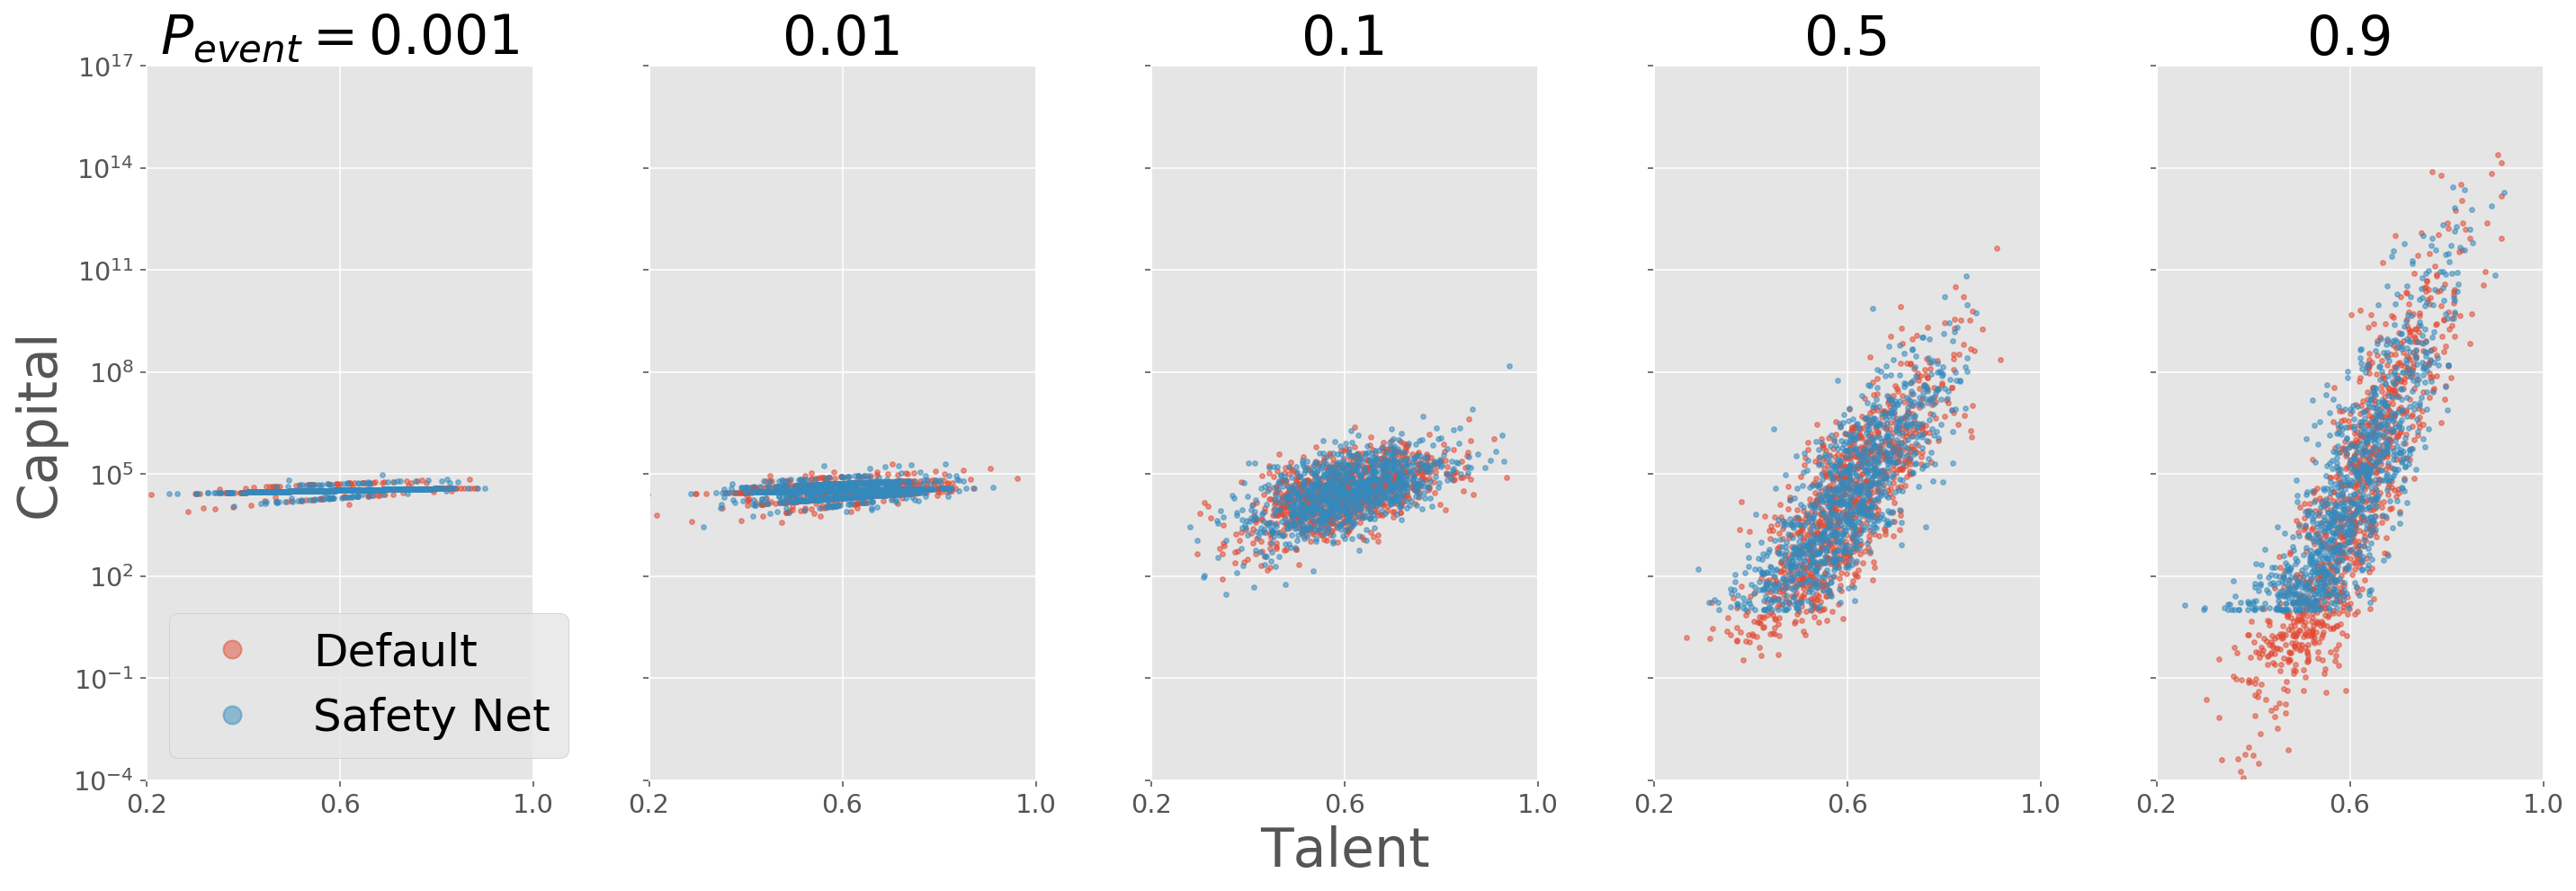

In [36]:
scatter_talent_capital_P_events_comparison(P_events, data_groupA, data_groupB, ylim=[10e-5, 10e16],
                                           labels={'A':'Default', 'B':'Safety Net'}, 
                                           fname='Figures/P_events_S6_default_vs_safety_net')